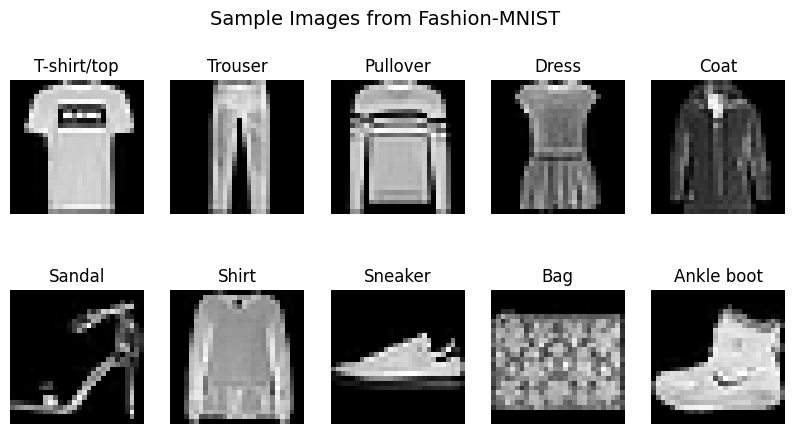

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist

# Initialize wandb
wandb.init(project="DA6401_Assignment1_ma23m011", name="sample-images-grid")

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Define class labels for Fashion-MNIST
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Get one example of each class
sample_images = []
sample_labels = []
for class_id in range(10):
    idx = np.where(y_train == class_id)[0][0]  # Find first occurrence of class_id
    sample_images.append(x_train[idx])
    sample_labels.append(class_labels[class_id])

# Log images to wandb
wandb.log({"Sample Images": [wandb.Image(img, caption=label) for img, label in zip(sample_images, sample_labels)]})

# Plot images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Sample Images from Fashion-MNIST", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(sample_labels[i])
    ax.axis("off")

plt.show()

# Finish wandb run
wandb.finish()


In [36]:
# # Normalize the input images (scale pixel values to [0,1])
# x_train = x_train.reshape(x_train.shape[0], -1) / 255.0  # Flatten 28x28 images to 784-dim vector
# x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# # Convert labels to one-hot encoding
# def one_hot_encode(y, num_classes=10):
#     one_hot = np.zeros((y.size, num_classes))
#     one_hot[np.arange(y.size), y] = 1
#     return one_hot

# y_train = one_hot_encode(y_train)
# y_val = one_hot_encode(y_val)
# y_test = one_hot_encode(y_test)
# # Print to verify
# print("y_train shape:", y_train.shape)  # (54000, 10)
# print("y_val shape:", y_val.shape)      # (6000, 10)
# print("y_test shape:", y_test.shape)      # (10000, 10)

# # Define the Feedforward Neural Network class
# class NeuralNetwork:
#     def __init__(self, input_size=784, hidden_layers=[128, 64], output_size=10):
#         """
#         Initializes a fully connected neural network.
#         Parameters:
#             input_size (int): Number of input neurons (784 for Fashion-MNIST).
#             hidden_layers (list): List containing the number of neurons in each hidden layer.
#             output_size (int): Number of output neurons (10 for classification).
#         """
#         self.layers = [input_size] + hidden_layers + [output_size]  # Layers including input & output
#         self.weights = []
#         self.biases = []

#         # Initialize weights and biases
#         for i in range(len(self.layers) - 1):
#             self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)
#             self.biases.append(np.zeros((1, self.layers[i+1])))

#     def sigmoid(self, z):
#         z = np.clip(z, -500, 500)  # Prevent extreme values
#         return 1 / (1 + np.exp(-z))

#     def softmax(self, z):
#         exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability trick
#         return exp_z / np.sum(exp_z, axis=1, keepdims=True)

#     def forward(self, X):
#         """
#         Forward pass through the network.
#         Returns activations of all layers.
#         """
#         activations = [X]
#         for i in range(len(self.weights) - 1):
#             z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
#             a = self.sigmoid(z)
#             activations.append(a)

#         # Output layer (softmax activation)
#         z_out = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
#         a_out = self.softmax(z_out)
#         activations.append(a_out)

#         return activations

#     def predict(self, X):
#         """
#         Predict class labels for given input.
#         """
#         output = self.forward(X)[-1]
#         return np.argmax(output, axis=1)


# # Create a neural network with a flexible architecture
# nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10)

# # Forward pass example
# sample_input = x_train[:5]  # Take 5 sample images
# output_probs = nn.forward(sample_input)[-1]  # Get output probability distribution

# # Print predictions
# print("Predicted class probabilities:\n", output_probs)
# print("Predicted classes:", np.argmax(output_probs, axis=1))


In [37]:
import numpy as np
from keras.datasets import fashion_mnist

# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize and flatten images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# Create validation set (last 6000 samples from training set)
x_val = x_train[54000:]
y_val = y_train[54000:]

# Use the first 54,000 samples for training
x_train = x_train[:54000]
y_train = y_train[:54000]

# Convert labels to one-hot encoding
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

# ------------------------------ Neural Network Class --------------------------------------
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[128, 64], output_size=10,
                 learning_rate=0.01, optimizer="sgd", weight_init="random",
                 activation="sigmoid", weight_decay=0.0):
        """
        Flexible Feedforward Neural Network with:
        - Weight Initialization: 'random' or 'xavier'
        - Activation Functions: 'sigmoid', 'tanh', 'relu'
        - Weight Decay (L2 Regularization): 0, 0.0005, 0.5
        """
        self.layers = [input_size] + hidden_layers + [output_size]
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.activation = activation
        self.weight_decay = weight_decay
        self.init_weights()

        # Optimizer-specific variables
        self.momentum = 0.9
        self.beta1 = 0.9  # Adam/Nadam
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.velocity = [np.zeros_like(w) for w in self.weights]
        self.squared_grads = [np.zeros_like(w) for w in self.weights]
        self.m = [np.zeros_like(w) for w in self.weights]
        self.v = [np.zeros_like(w) for w in self.weights]
        self.t = 0  # Time step

    def init_weights(self):
        """ Initialize weights and biases based on chosen method. """
        self.weights = []
        self.biases = []
        for i in range(len(self.layers) - 1):
            if self.weight_init == "random":
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)
            elif self.weight_init == "xavier":
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(1 / self.layers[i]))
            self.biases.append(np.zeros((1, self.layers[i+1])))

    def activation_function(self, z):
        """ Compute activation function based on user choice. """
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-np.clip(z, -10, 10)))  # Prevent overflow
        elif self.activation == "tanh":
            return np.tanh(z)
        elif self.activation == "relu":
            return np.maximum(0, z)

    def activation_derivative(self, a):
        """ Compute derivative of activation function. """
        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """ Forward pass through the network. """
        activations = [X]
        z_values = []

        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            activations.append(self.activation_function(z))

        z_out = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        z_values.append(z_out)
        activations.append(self.softmax(z_out))

        return activations, z_values

    def compute_loss(self, y_true, y_pred):
        """ Compute cross-entropy loss with optional L2 regularization. """
        loss = -np.sum(y_true * np.log(y_pred + self.epsilon)) / y_true.shape[0]
        l2_penalty = self.weight_decay * sum(np.sum(w**2) for w in self.weights) / 2
        return loss + l2_penalty

    def compute_accuracy(self, y_true, y_pred):
        """ Compute accuracy by comparing true vs predicted labels. """
        correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        return correct_predictions / y_true.shape[0]

    def backward(self, X, y_true, activations, z_values):
        """ Backpropagation to compute gradients. """
        gradients_w = [np.zeros_like(w) for w in self.weights]
        gradients_b = [np.zeros_like(b) for b in self.biases]

        # Output layer gradient
        dL_dz = activations[-1] - y_true
        gradients_w[-1] = np.dot(activations[-2].T, dL_dz) + self.weight_decay * self.weights[-1]
        gradients_b[-1] = np.sum(dL_dz, axis=0, keepdims=True)

        # Hidden layers
        for i in reversed(range(len(self.weights) - 1)):
            dL_dz = np.dot(dL_dz, self.weights[i+1].T) * self.activation_derivative(activations[i+1])
            gradients_w[i] = np.dot(activations[i].T, dL_dz) + self.weight_decay * self.weights[i]
            gradients_b[i] = np.sum(dL_dz, axis=0, keepdims=True)

        return gradients_w, gradients_b

    def update_weights(self, gradients_w, gradients_b):
        """ Apply gradient updates using different optimizers. """
        self.t += 1  # Update time step for Adam/Nadam

        for i in range(len(self.weights)):
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * gradients_w[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]

            elif self.optimizer == "momentum":
                self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * gradients_w[i]
                self.weights[i] += self.velocity[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]

            elif self.optimizer == "nesterov":
                temp_weights = self.weights[i] + self.momentum * self.velocity[i]
                self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * gradients_w[i]
                self.weights[i] = temp_weights + self.velocity[i]

            elif self.optimizer == "rmsprop":
                self.squared_grads[i] = 0.9 * self.squared_grads[i] + 0.1 * (gradients_w[i] ** 2)
                self.weights[i] -= self.learning_rate * gradients_w[i] / (np.sqrt(self.squared_grads[i]) + self.epsilon)

            elif self.optimizer == "adam":
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients_w[i]
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gradients_w[i] ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            elif self.optimizer == "nadam":
                m_hat = (self.beta1 * self.m[i] + (1 - self.beta1) * gradients_w[i]) / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * (self.momentum * m_hat + (1 - self.momentum) * gradients_w[i]) / (np.sqrt(v_hat) + self.epsilon)

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """ Train the network using mini-batch gradient descent and track accuracy. """
        num_samples = X_train.shape[0]

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            # Mini-batch training
            for i in range(0, num_samples, batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                # Forward pass
                activations, z_values = self.forward(X_batch)

                # Compute gradients
                gradients_w, gradients_b = self.backward(X_batch, y_batch, activations, z_values)

                # Update weights
                self.update_weights(gradients_w, gradients_b)

            # Compute training loss & accuracy
            train_activations, _ = self.forward(X_train)
            Train_loss = self.compute_loss(y_train, train_activations[-1])
            Train_accuracy = compute_accuracy(y_train, train_activations[-1])

            # Compute validation loss & accuracy
            val_activations, _ = self.forward(X_val)
            Val_loss = self.compute_loss(y_val, val_activations[-1])
            Val_accuracy = compute_accuracy(y_val, val_activations[-1])
            wandb.log({'Train_loss': Train_loss})
            wandb.log({'Train_accuracy': Train_accuracy })
            wandb.log({'epoch': epoch + 1})
            wandb.log({'Val_loss': Val_loss})
            wandb.log({'Val_accuracy': Val_accuracy })

            print(f"Epoch {epoch+1}: Train Loss = {Train_loss:.4f}, Train Acc = {Train_accuracy:.4f}, Val Loss = {Val_loss:.4f}, Val Acc = {Val_accuracy:.4f}")

def compute_accuracy(y_true, y_pred):
        """ Compute accuracy by comparing true vs predicted labels. """
        correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        accuracy = correct_predictions / y_true.shape[0]
        return accuracy*100

In [38]:
# # Flatten both training and validation sets
# x_train = x_train.reshape(x_train.shape[0], -1)  # (54000, 784)
# x_val = x_val.reshape(x_val.shape[0], -1)  # (6000, 784)

# # Create Neural Network
# nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10, learning_rate=0.01, optimizer="sgd", weight_init="xavier", activation="relu", weight_decay=0.0005)

# # Train the model and track accuracy
# nn.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=32)


In [39]:
!pip install wandb

In [40]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [41]:
key = input('Enter your API:')
wandb.login(key=key)

Enter your API:580e769ee2f34eafdded556ce52aaf31c265ad3b


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [43]:
sweep_config = {
    'method': 'bayes',
    'name' : 'sweep cross entropy-1',
    'metric': {
      'name': 'Val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers':{
            'values':[3,4,5]
        },
         'hidden_size':{
            'values':[32,64,128]
        },
        'weight_decay':{
            'values':[0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['rmsprop', 'nadam','adam', 'nag','mgd','sgd']
        },
        'batch_size':{
            'values':[16,32,64]
        },
        'weight_init': {
            'values': ['xavier','random']
        },
        'activation': {
            'values': ['relu','tanh','sigmoid']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_Assignment1_ma23m011')

Create sweep with ID: pn73b6ya
Sweep URL: https://wandb.ai/ma23m011-iit-madras/DA6401_Assignment1_ma23m011/sweeps/pn73b6ya


In [44]:
def main():
    with wandb.init() as run:
        run_name="-ac_"+wandb.config.activation+"-hs_"+str(wandb.config.hidden_size)+"-epc_"+str(wandb.config.epochs)+"-hl_"+str(wandb.config.hidden_layers)+"-regu_"+str(wandb.config.weight_decay)+"-eta_"+str(wandb.config.learning_rate)+"-optmz_"+wandb.config.optimizer+"-batch_"+str(wandb.config.batch_size)+"-wght_"+wandb.config.weight_init
        wandb.run.name=run_name
        nn = NeuralNetwork(input_size=784, hidden_layers=[wandb.config.hidden_size] * wandb.config.hidden_layers, output_size=10, learning_rate=wandb.config.learning_rate, optimizer=wandb.config.optimizer, weight_init=wandb.config.weight_init, activation=wandb.config.activation, weight_decay=wandb.config.weight_decay)
        nn.train(x_train, y_train, x_val, y_val, epochs=wandb.config.epochs, batch_size=wandb.config.batch_size)


# # Create Neural Network
# nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10, learning_rate=0.01, optimizer="sgd")

# # Train the model and track accuracy
# nn.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=32)

wandb.agent(sweep_id, function=main,count=100) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: pqikavgw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 2: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 3: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 4: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 5: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 6: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 7: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 8: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 9: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500
Epoch 10: Train Loss = 2.3889, Train Acc = 10.1185, Val Loss = 2.3892, Val Acc = 9.8500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.11852
Train_loss,2.38893
Val_accuracy,9.85
Val_loss,2.38918
epoch,10


wandb: Agent Starting Run: 5jhqt0zc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: mj9za5ru with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.6080, Train Acc = 29.0759, Val Loss = 1.6018, Val Acc = 29.9000
Epoch 2: Train Loss = 1.1607, Train Acc = 50.6667, Val Loss = 1.1571, Val Acc = 51.3500
Epoch 3: Train Loss = 1.0393, Train Acc = 56.5426, Val Loss = 1.0389, Val Acc = 56.6167
Epoch 4: Train Loss = 0.9687, Train Acc = 62.3296, Val Loss = 0.9709, Val Acc = 61.7833
Epoch 5: Train Loss = 0.8790, Train Acc = 69.2741, Val Loss = 0.8850, Val Acc = 69.3667


Train_accuracy,▁▅▆▇█
Train_loss,█▄▃▂▁
Val_accuracy,▁▅▆▇█
Val_loss,█▄▃▂▁
epoch,▁▃▅▆█
Train_accuracy,69.27407
Train_loss,0.879
Val_accuracy,69.36667
Val_loss,0.88503
epoch,5


wandb: Agent Starting Run: kp8oxs1e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.3967, Train Acc = 47.5259, Val Loss = 1.3957, Val Acc = 47.5667
Epoch 2: Train Loss = 1.2568, Train Acc = 61.2389, Val Loss = 1.2639, Val Acc = 60.6500
Epoch 3: Train Loss = 1.1166, Train Acc = 74.2037, Val Loss = 1.1216, Val Acc = 74.4333
Epoch 4: Train Loss = 1.0405, Train Acc = 80.5185, Val Loss = 1.0608, Val Acc = 80.0833
Epoch 5: Train Loss = 0.9864, Train Acc = 84.1852, Val Loss = 1.0074, Val Acc = 83.1167
Epoch 6: Train Loss = 0.9669, Train Acc = 85.9519, Val Loss = 0.9944, Val Acc = 84.8167
Epoch 7: Train Loss = 0.9888, Train Acc = 85.5852, Val Loss = 1.0179, Val Acc = 84.5833
Epoch 8: Train Loss = 0.9779, Train Acc = 86.6296, Val Loss = 1.0186, Val Acc = 85.4000
Epoch 9: Train Loss = 0.9736, Train Acc = 87.6500, Val Loss = 1.0122, Val Acc = 86.1667
Epoch 10: Train Loss = 0.9726, Train Acc = 88.1074, Val Loss = 1.0167, Val Acc = 86.5333


Train_accuracy,▁▃▆▇▇█████
Train_loss,█▆▃▂▁▁▁▁▁▁
Val_accuracy,▁▃▆▇▇█████
Val_loss,█▆▃▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,88.10741
Train_loss,0.97259
Val_accuracy,86.53333
Val_loss,1.01671
epoch,10


wandb: Agent Starting Run: z7e5sovt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: te5i9ghr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: bseiqmqe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.7648, Train Acc = 83.4222, Val Loss = 0.7747, Val Acc = 83.2333
Epoch 2: Train Loss = 0.7899, Train Acc = 84.2407, Val Loss = 0.7984, Val Acc = 83.6333
Epoch 3: Train Loss = 0.7733, Train Acc = 86.7000, Val Loss = 0.7961, Val Acc = 86.1833
Epoch 4: Train Loss = 0.8072, Train Acc = 86.9981, Val Loss = 0.8352, Val Acc = 86.1000
Epoch 5: Train Loss = 0.8230, Train Acc = 87.5463, Val Loss = 0.8585, Val Acc = 86.1167


Train_accuracy,▁▂▇▇█
Train_loss,▁▄▂▆█
Val_accuracy,▁▂███
Val_loss,▁▃▃▆█
epoch,▁▃▅▆█
Train_accuracy,87.5463
Train_loss,0.82301
Val_accuracy,86.11667
Val_loss,0.85846
epoch,5


wandb: Agent Starting Run: x1nd5gm4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 2: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 3: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 4: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 5: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 6: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 7: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 8: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 9: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500
Epoch 10: Train Loss = 28.4947, Train Acc = 11.4037, Val Loss = 28.4950, Val Acc = 11.6500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,11.4037
Train_loss,28.49471
Val_accuracy,11.65
Val_loss,28.49495
epoch,10


wandb: Agent Starting Run: 6m5gags5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9889, Val Loss = 2.3026, Val Acc = 10.4833
Epoch 3: Train Loss = 2.3026, Train Acc = 9.7074, Val Loss = 2.3026, Val Acc = 10.1500
Epoch 4: Train Loss = 2.3026, Train Acc = 7.0093, Val Loss = 2.3026, Val Acc = 6.5333
Epoch 5: Train Loss = 2.3026, Train Acc = 7.7741, Val Loss = 2.3026, Val Acc = 8.5333
Epoch 6: Train Loss = 2.3026, Train Acc = 7.7759, Val Loss = 2.3026, Val Acc = 7.9333
Epoch 7: Train Loss = 2.3026, Train Acc = 10.1019, Val Loss = 2.3026, Val Acc = 9.5000
Epoch 8: Train Loss = 2.3026, Train Acc = 11.5426, Val Loss = 2.3026, Val Acc = 11.4000
Epoch 9: Train Loss = 2.3026, Train Acc = 8.5111, Val Loss = 2.3026, Val Acc = 8.4833
Epoch 10: Train Loss = 2.3026, Train Acc = 9.7519, Val Loss = 2.3026, Val Acc = 9.8667


Train_accuracy,▆▆▅▁▂▂▆█▃▅
Train_loss,▁▁▂▃▃█▆▅▄▂
Val_accuracy,▇▇▆▁▄▃▅█▄▆
Val_loss,▁▁▂▃▃█▆▅▄▂
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.75185
Train_loss,2.30259
Val_accuracy,9.86667
Val_loss,2.30259
epoch,10


wandb: Agent Starting Run: hvql5pwa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3008, Train Acc = 8.0889, Val Loss = 2.2996, Val Acc = 8.5667
Epoch 2: Train Loss = 2.3008, Train Acc = 8.0889, Val Loss = 2.2996, Val Acc = 8.5667
Epoch 3: Train Loss = 2.3008, Train Acc = 8.0889, Val Loss = 2.2996, Val Acc = 8.5667
Epoch 4: Train Loss = 2.3008, Train Acc = 8.0889, Val Loss = 2.2996, Val Acc = 8.5667
Epoch 5: Train Loss = 2.3008, Train Acc = 8.0889, Val Loss = 2.2996, Val Acc = 8.5667


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,8.08889
Train_loss,2.30076
Val_accuracy,8.56667
Val_loss,2.29962
epoch,5


wandb: Agent Starting Run: n2ujfwes with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.0053, Train Acc = 26.8685, Val Loss = 2.0057, Val Acc = 26.8500
Epoch 2: Train Loss = 1.5048, Train Acc = 43.3667, Val Loss = 1.5041, Val Acc = 43.6500
Epoch 3: Train Loss = 1.2202, Train Acc = 55.8370, Val Loss = 1.2176, Val Acc = 55.9833
Epoch 4: Train Loss = 1.0455, Train Acc = 58.9019, Val Loss = 1.0419, Val Acc = 59.3667
Epoch 5: Train Loss = 0.9274, Train Acc = 64.3519, Val Loss = 0.9250, Val Acc = 64.8500
Epoch 6: Train Loss = 0.8557, Train Acc = 66.7981, Val Loss = 0.8551, Val Acc = 66.7833
Epoch 7: Train Loss = 0.8055, Train Acc = 68.1778, Val Loss = 0.8057, Val Acc = 68.2833
Epoch 8: Train Loss = 0.7650, Train Acc = 69.3259, Val Loss = 0.7654, Val Acc = 69.4000
Epoch 9: Train Loss = 0.7318, Train Acc = 71.1852, Val Loss = 0.7318, Val Acc = 71.2833
Epoch 10: Train Loss = 0.7027, Train Acc = 72.4870, Val Loss = 0.7044, Val Acc = 72.4167


Train_accuracy,▁▄▅▆▇▇▇███
Train_loss,█▅▄▃▂▂▂▁▁▁
Val_accuracy,▁▄▅▆▇▇▇███
Val_loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,72.48704
Train_loss,0.70267
Val_accuracy,72.41667
Val_loss,0.70445
epoch,10


wandb: Agent Starting Run: iqwnzqn2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 19.6202, Train Acc = 76.7444, Val Loss = 19.6113, Val Acc = 76.9333
Epoch 2: Train Loss = 17.3420, Train Acc = 79.5722, Val Loss = 17.3387, Val Acc = 79.6833
Epoch 3: Train Loss = 16.1796, Train Acc = 80.7907, Val Loss = 16.1813, Val Acc = 80.3167
Epoch 4: Train Loss = 15.4285, Train Acc = 81.3093, Val Loss = 15.4251, Val Acc = 81.3167
Epoch 5: Train Loss = 14.8795, Train Acc = 81.6778, Val Loss = 14.8792, Val Acc = 81.5500
Epoch 6: Train Loss = 14.4514, Train Acc = 81.8648, Val Loss = 14.4526, Val Acc = 82.0167
Epoch 7: Train Loss = 14.0672, Train Acc = 82.3167, Val Loss = 14.0670, Val Acc = 81.9333
Epoch 8: Train Loss = 13.7816, Train Acc = 82.0204, Val Loss = 13.7807, Val Acc = 81.5667
Epoch 9: Train Loss = 13.5089, Train Acc = 82.7444, Val Loss = 13.5111, Val Acc = 82.4333
Epoch 10: Train Loss = 13.3317, Train Acc = 81.8148, Val Loss = 13.3354, Val Acc = 81.8500


Train_accuracy,▁▄▆▆▇▇█▇█▇
Train_loss,█▅▄▃▃▂▂▂▁▁
Val_accuracy,▁▅▅▇▇▇▇▇█▇
Val_loss,█▅▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,81.81481
Train_loss,13.33175
Val_accuracy,81.85
Val_loss,13.33544
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c7e44jxk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 2: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 3: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 4: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 5: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 6: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 7: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 8: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 9: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833
Epoch 10: Train Loss = 2.4466, Train Acc = 9.9907, Val Loss = 2.4411, Val Acc = 10.0833


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,2.44661
Val_accuracy,10.08333
Val_loss,2.44109
epoch,10


wandb: Agent Starting Run: t1ppkk22 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3359, Train Acc = 9.9389, Val Loss = 2.3357, Val Acc = 10.5500
Epoch 2: Train Loss = 2.3341, Train Acc = 9.9648, Val Loss = 2.3338, Val Acc = 10.3167
Epoch 3: Train Loss = 2.3345, Train Acc = 9.9389, Val Loss = 2.3344, Val Acc = 10.5500
Epoch 4: Train Loss = 2.3330, Train Acc = 9.9907, Val Loss = 2.3331, Val Acc = 10.0833
Epoch 5: Train Loss = 2.3328, Train Acc = 10.0833, Val Loss = 2.3335, Val Acc = 9.2500


Train_accuracy,▁▂▁▄█
Train_loss,█▄▅▂▁
Val_accuracy,█▇█▅▁
Val_loss,█▃▄▁▂
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,2.33279
Val_accuracy,9.25
Val_loss,2.3335
epoch,5


wandb: Agent Starting Run: ehqphxco with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 2: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 3: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 4: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 5: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 6: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 7: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 8: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 9: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500
Epoch 10: Train Loss = 2.3813, Train Acc = 11.4833, Val Loss = 2.3803, Val Acc = 11.6500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,11.48333
Train_loss,2.38129
Val_accuracy,11.65
Val_loss,2.38033
epoch,10


wandb: Agent Starting Run: hzawza8l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 12.7505, Train Acc = 30.7815, Val Loss = 12.5660, Val Acc = 31.7833
Epoch 2: Train Loss = 11.4761, Train Acc = 37.7000, Val Loss = 11.5498, Val Acc = 37.3000
Epoch 3: Train Loss = 12.0748, Train Acc = 34.4500, Val Loss = 12.0195, Val Acc = 34.7500
Epoch 4: Train Loss = 12.4033, Train Acc = 32.6667, Val Loss = 12.5506, Val Acc = 31.8667
Epoch 5: Train Loss = 14.8795, Train Acc = 19.2241, Val Loss = 14.9760, Val Acc = 18.7000
Epoch 6: Train Loss = 12.4005, Train Acc = 32.6815, Val Loss = 12.5445, Val Acc = 31.9000
Epoch 7: Train Loss = 12.9968, Train Acc = 29.4444, Val Loss = 13.0449, Val Acc = 29.1833
Epoch 8: Train Loss = 11.0429, Train Acc = 40.0519, Val Loss = 10.9450, Val Acc = 40.5833
Epoch 9: Train Loss = 13.0674, Train Acc = 29.0611, Val Loss = 12.8853, Val Acc = 30.0500
Epoch 10: Train Loss = 10.9927, Train Acc = 40.3241, Val Loss = 10.8682, Val Acc = 41.0000


Train_accuracy,▅▇▆▅▁▅▄█▄█
Train_loss,▄▂▃▄█▄▅▁▅▁
Val_accuracy,▅▇▆▅▁▅▄█▅█
Val_loss,▄▂▃▄█▄▅▁▄▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,40.32407
Train_loss,10.99271
Val_accuracy,41
Val_loss,10.8682
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o2h5dlua with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3042, Train Acc = 10.0833, Val Loss = 2.3042, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3042, Train Acc = 10.0648, Val Loss = 2.3043, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3042, Train Acc = 10.0833, Val Loss = 2.3043, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3042, Train Acc = 10.0648, Val Loss = 2.3043, Val Acc = 9.4167
Epoch 5: Train Loss = 2.3041, Train Acc = 10.0648, Val Loss = 2.3043, Val Acc = 9.4167


Train_accuracy,█▁█▁▁
Train_loss,█▄▂▃▁
Val_accuracy,▁█▁██
Val_loss,▁▄▇▇█
epoch,▁▃▅▆█
Train_accuracy,10.06481
Train_loss,2.30415
Val_accuracy,9.41667
Val_loss,2.30434
epoch,5


wandb: Agent Starting Run: 9cn48xx8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.0214, Train Acc = 10.0167, Val Loss = 3.0213, Val Acc = 9.8500
Epoch 2: Train Loss = 3.0214, Train Acc = 10.0167, Val Loss = 3.0213, Val Acc = 9.8500
Epoch 3: Train Loss = 3.0214, Train Acc = 10.0167, Val Loss = 3.0213, Val Acc = 9.8500
Epoch 4: Train Loss = 3.0214, Train Acc = 10.0167, Val Loss = 3.0213, Val Acc = 9.8500
Epoch 5: Train Loss = 3.0214, Train Acc = 10.0167, Val Loss = 3.0213, Val Acc = 9.8500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.01667
Train_loss,3.02142
Val_accuracy,9.85
Val_loss,3.02127
epoch,5


wandb: Agent Starting Run: zxgivdc6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.2867, Train Acc = 40.8426, Val Loss = 1.2887, Val Acc = 39.8333
Epoch 2: Train Loss = 0.9319, Train Acc = 66.2407, Val Loss = 0.9363, Val Acc = 65.9833
Epoch 3: Train Loss = 0.7679, Train Acc = 74.3074, Val Loss = 0.7843, Val Acc = 73.9000
Epoch 4: Train Loss = 0.7584, Train Acc = 76.7593, Val Loss = 0.7937, Val Acc = 75.8167
Epoch 5: Train Loss = 0.6721, Train Acc = 81.4833, Val Loss = 0.6959, Val Acc = 80.7000
Epoch 6: Train Loss = 0.6423, Train Acc = 82.9704, Val Loss = 0.6741, Val Acc = 81.8167
Epoch 7: Train Loss = 0.5666, Train Acc = 85.3815, Val Loss = 0.6067, Val Acc = 83.7833
Epoch 8: Train Loss = 0.5574, Train Acc = 85.4481, Val Loss = 0.6033, Val Acc = 84.0667
Epoch 9: Train Loss = 0.5336, Train Acc = 86.3796, Val Loss = 0.5793, Val Acc = 85.2333
Epoch 10: Train Loss = 0.5239, Train Acc = 87.0981, Val Loss = 0.5596, Val Acc = 85.7000


Train_accuracy,▁▅▆▆▇▇████
Train_loss,█▅▃▃▂▂▁▁▁▁
Val_accuracy,▁▅▆▆▇▇████
Val_loss,█▅▃▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,87.09815
Train_loss,0.52394
Val_accuracy,85.7
Val_loss,0.55964
epoch,10


wandb: Agent Starting Run: ysmslsv9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: tnf18a25 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.6924, Train Acc = 76.5593, Val Loss = 0.6849, Val Acc = 77.2500
Epoch 2: Train Loss = 0.5289, Train Acc = 81.5444, Val Loss = 0.5311, Val Acc = 81.2833
Epoch 3: Train Loss = 0.4709, Train Acc = 83.4741, Val Loss = 0.4741, Val Acc = 82.9667
Epoch 4: Train Loss = 0.4456, Train Acc = 84.3241, Val Loss = 0.4531, Val Acc = 83.6000
Epoch 5: Train Loss = 0.4456, Train Acc = 84.0074, Val Loss = 0.4581, Val Acc = 83.5500
Epoch 6: Train Loss = 0.4090, Train Acc = 85.6352, Val Loss = 0.4210, Val Acc = 84.6000
Epoch 7: Train Loss = 0.4025, Train Acc = 85.6370, Val Loss = 0.4150, Val Acc = 84.5167
Epoch 8: Train Loss = 0.3880, Train Acc = 86.2630, Val Loss = 0.4025, Val Acc = 85.2167
Epoch 9: Train Loss = 0.3881, Train Acc = 86.2685, Val Loss = 0.4056, Val Acc = 85.1167
Epoch 10: Train Loss = 0.3755, Train Acc = 86.5741, Val Loss = 0.3930, Val Acc = 85.6500


Train_accuracy,▁▄▆▆▆▇▇███
Train_loss,█▄▃▃▃▂▂▁▁▁
Val_accuracy,▁▄▆▆▆▇▇███
Val_loss,█▄▃▂▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,86.57407
Train_loss,0.37551
Val_accuracy,85.65
Val_loss,0.39296
epoch,10


wandb: Agent Starting Run: n32memxl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 53.3044, Train Acc = 9.4463, Val Loss = 53.3057, Val Acc = 9.2500
Epoch 2: Train Loss = 53.3044, Train Acc = 9.4463, Val Loss = 53.3057, Val Acc = 9.2500
Epoch 3: Train Loss = 53.3044, Train Acc = 9.4463, Val Loss = 53.3057, Val Acc = 9.2500
Epoch 4: Train Loss = 53.3044, Train Acc = 9.4463, Val Loss = 53.3057, Val Acc = 9.2500
Epoch 5: Train Loss = 53.3044, Train Acc = 9.4463, Val Loss = 53.3057, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.4463
Train_loss,53.30436
Val_accuracy,9.25
Val_loss,53.30575
epoch,5


wandb: Agent Starting Run: u7j8ydnc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 100.7148, Train Acc = 11.3556, Val Loss = 100.7186, Val Acc = 11.4667
Epoch 2: Train Loss = 100.7148, Train Acc = 11.3556, Val Loss = 100.7186, Val Acc = 11.4667
Epoch 3: Train Loss = 100.7148, Train Acc = 11.3556, Val Loss = 100.7186, Val Acc = 11.4667
Epoch 4: Train Loss = 100.7148, Train Acc = 11.3556, Val Loss = 100.7186, Val Acc = 11.4667
Epoch 5: Train Loss = 100.7148, Train Acc = 11.3556, Val Loss = 100.7186, Val Acc = 11.4667


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,11.35556
Train_loss,100.71476
Val_accuracy,11.46667
Val_loss,100.71859
epoch,5


wandb: Agent Starting Run: 2daos815 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 10.0815, Val Loss = 2.3026, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3026, Train Acc = 10.0815, Val Loss = 2.3026, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3026, Train Acc = 10.0815, Val Loss = 2.3026, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3026, Train Acc = 10.0815, Val Loss = 2.3026, Val Acc = 9.2500
Epoch 5: Train Loss = 2.3026, Train Acc = 10.0815, Val Loss = 2.3026, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.08148
Train_loss,2.3026
Val_accuracy,9.25
Val_loss,2.3026
epoch,5


wandb: Agent Starting Run: 3zp8vf6v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 2: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 3: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 4: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 5: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 6: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 7: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 8: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 9: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667
Epoch 10: Train Loss = 2.3068, Train Acc = 13.8704, Val Loss = 2.3068, Val Acc = 14.5667


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,13.87037
Train_loss,2.30678
Val_accuracy,14.56667
Val_loss,2.30678
epoch,10


wandb: Agent Starting Run: 7r74jb4u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 2: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 3: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 4: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 5: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 6: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 7: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 8: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 9: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333
Epoch 10: Train Loss = 2.3277, Train Acc = 9.9963, Val Loss = 2.3267, Val Acc = 10.0333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.9963
Train_loss,2.32766
Val_accuracy,10.03333
Val_loss,2.32673
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 17ryo8ye with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 2: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 3: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 4: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 5: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 6: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 7: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 8: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 9: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500
Epoch 10: Train Loss = 3.7757, Train Acc = 12.7500, Val Loss = 3.7757, Val Acc = 12.7500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,12.75
Train_loss,3.77571
Val_accuracy,12.75
Val_loss,3.77571
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9rfew1k9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 589695825.0283, Train Acc = 10.0648, Val Loss = 589695825.0283, Val Acc = 9.4167
Epoch 2: Train Loss = 19888894416010.6641, Train Acc = 9.9389, Val Loss = 19888894416010.6680, Val Acc = 10.5500
Epoch 3: Train Loss = 3284790.0979, Train Acc = 9.9444, Val Loss = 3284790.0979, Val Acc = 10.5000
Epoch 4: Train Loss = 39398397.6422, Train Acc = 10.0167, Val Loss = 39398397.6421, Val Acc = 9.8500
Epoch 5: Train Loss = 14.8934, Train Acc = 10.0833, Val Loss = 15.0184, Val Acc = 9.2500
Epoch 6: Train Loss = 380529657714.3930, Train Acc = 9.9963, Val Loss = 380529657714.3568, Val Acc = 10.0333
Epoch 7: Train Loss = 452803322442.4761, Train Acc = 9.9648, Val Loss = 452803322442.4760, Val Acc = 10.3167
Epoch 8: Train Loss = 6414124107.5099, Train Acc = 10.0296, Val Loss = 6414124107.5100, Val Acc = 9.7333
Epoch 9: Train Loss = 4873974.7644, Train Acc = 10.0296, Val Loss = 4873974.8190, Val Acc = 9.7333
Epoch 10: Train Loss = 18203.6031, Train Acc = 10.0167, Val Loss = 18203.

Train_accuracy,▇▁▁▅█▄▂▅▅▅
Train_loss,▁█▁▁▁▁▁▁▁▁
Val_accuracy,▂██▄▁▅▇▄▄▄
Val_loss,▁█▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.01667
Train_loss,18203.60313
Val_accuracy,9.85
Val_loss,18203.60344
epoch,10


wandb: Agent Starting Run: twzz02xg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 2: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 3: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 4: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 5: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 6: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 7: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 8: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 9: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167
Epoch 10: Train Loss = 2.6344, Train Acc = 9.9648, Val Loss = 2.6313, Val Acc = 10.3167


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.96481
Train_loss,2.63439
Val_accuracy,10.31667
Val_loss,2.63134
epoch,10


wandb: Agent Starting Run: d19v1hmd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 16.5844, Train Acc = 9.9685, Val Loss = 16.5203, Val Acc = 10.3167
Epoch 2: Train Loss = 16.5305, Train Acc = 10.2611, Val Loss = 16.5479, Val Acc = 10.1667
Epoch 3: Train Loss = 16.4814, Train Acc = 10.5278, Val Loss = 16.5080, Val Acc = 10.3833
Epoch 4: Train Loss = 16.5373, Train Acc = 10.2241, Val Loss = 16.4957, Val Acc = 10.4500
Epoch 5: Train Loss = 16.4920, Train Acc = 10.4704, Val Loss = 16.4128, Val Acc = 10.9000


Train_accuracy,▁▅█▄▇
Train_loss,█▄▁▅▂
Val_accuracy,▂▁▃▄█
Val_loss,▇█▆▅▁
epoch,▁▃▅▆█
Train_accuracy,10.47037
Train_loss,16.49197
Val_accuracy,10.9
Val_loss,16.41283
epoch,5


wandb: Agent Starting Run: 2h6c0nb4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.0859, Train Acc = 10.0296, Val Loss = 2.0825, Val Acc = 9.7333
Epoch 2: Train Loss = 2.0641, Train Acc = 10.0648, Val Loss = 2.0599, Val Acc = 9.4167
Epoch 3: Train Loss = 2.0507, Train Acc = 9.9389, Val Loss = 2.0483, Val Acc = 10.5500
Epoch 4: Train Loss = 2.0417, Train Acc = 9.9963, Val Loss = 2.0400, Val Acc = 10.0333
Epoch 5: Train Loss = 2.0357, Train Acc = 9.9907, Val Loss = 2.0332, Val Acc = 10.0833


Train_accuracy,▆█▁▄▄
Train_loss,█▅▃▂▁
Val_accuracy,▃▁█▅▅
Val_loss,█▅▃▂▁
epoch,▁▃▅▆█
Train_accuracy,9.99074
Train_loss,2.03567
Val_accuracy,10.08333
Val_loss,2.03325
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mfq34vzq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


<ipython-input-37-b7f5dafee785>:89: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: rigli3vr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 11.2778, Val Loss = 2.3026, Val Acc = 10.9667
Epoch 2: Train Loss = 2.3026, Train Acc = 11.2778, Val Loss = 2.3026, Val Acc = 10.9667
Epoch 3: Train Loss = 2.3026, Train Acc = 11.2778, Val Loss = 2.3026, Val Acc = 10.9667
Epoch 4: Train Loss = 2.3026, Train Acc = 11.2778, Val Loss = 2.3026, Val Acc = 10.9667
Epoch 5: Train Loss = 2.3026, Train Acc = 11.2778, Val Loss = 2.3026, Val Acc = 10.9667


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,11.27778
Train_loss,2.30258
Val_accuracy,10.96667
Val_loss,2.30258
epoch,5


wandb: Agent Starting Run: qpll2ypw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.2922, Train Acc = 59.2537, Val Loss = 1.2826, Val Acc = 60.2833
Epoch 2: Train Loss = 1.0411, Train Acc = 71.9759, Val Loss = 1.0338, Val Acc = 72.6000
Epoch 3: Train Loss = 0.9563, Train Acc = 76.9185, Val Loss = 0.9538, Val Acc = 77.4833
Epoch 4: Train Loss = 0.9357, Train Acc = 77.5093, Val Loss = 0.9297, Val Acc = 78.0167
Epoch 5: Train Loss = 0.9155, Train Acc = 78.7278, Val Loss = 0.9254, Val Acc = 78.7000
Epoch 6: Train Loss = 0.8973, Train Acc = 79.9037, Val Loss = 0.9048, Val Acc = 79.8167
Epoch 7: Train Loss = 0.8911, Train Acc = 80.9056, Val Loss = 0.8952, Val Acc = 80.7667
Epoch 8: Train Loss = 0.8762, Train Acc = 82.6407, Val Loss = 0.8878, Val Acc = 82.1500
Epoch 9: Train Loss = 0.8691, Train Acc = 83.3370, Val Loss = 0.8787, Val Acc = 82.5667
Epoch 10: Train Loss = 0.8683, Train Acc = 83.8222, Val Loss = 0.8817, Val Acc = 82.9833


Train_accuracy,▁▅▆▆▇▇▇███
Train_loss,█▄▂▂▂▁▁▁▁▁
Val_accuracy,▁▅▆▆▇▇▇███
Val_loss,█▄▂▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,83.82222
Train_loss,0.86827
Val_accuracy,82.98333
Val_loss,0.88166
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zcujntku with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.8722, Train Acc = 61.4000, Val Loss = 0.8705, Val Acc = 61.3500
Epoch 2: Train Loss = 0.7259, Train Acc = 71.3352, Val Loss = 0.7325, Val Acc = 71.0000
Epoch 3: Train Loss = 0.6612, Train Acc = 73.1685, Val Loss = 0.6723, Val Acc = 72.7500
Epoch 4: Train Loss = 0.5956, Train Acc = 78.8852, Val Loss = 0.6182, Val Acc = 78.2833
Epoch 5: Train Loss = 0.5438, Train Acc = 81.1333, Val Loss = 0.5756, Val Acc = 81.0000
Epoch 6: Train Loss = 0.5429, Train Acc = 81.2130, Val Loss = 0.5772, Val Acc = 80.7000
Epoch 7: Train Loss = 0.5161, Train Acc = 82.3074, Val Loss = 0.5561, Val Acc = 80.9167
Epoch 8: Train Loss = 0.4675, Train Acc = 83.8148, Val Loss = 0.5041, Val Acc = 82.7333
Epoch 9: Train Loss = 0.4452, Train Acc = 85.4093, Val Loss = 0.4978, Val Acc = 83.8333
Epoch 10: Train Loss = 0.4356, Train Acc = 85.3204, Val Loss = 0.4885, Val Acc = 84.2333


Train_accuracy,▁▄▄▆▇▇▇███
Train_loss,█▆▅▄▃▃▂▂▁▁
Val_accuracy,▁▄▄▆▇▇▇███
Val_loss,█▅▄▃▃▃▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,85.32037
Train_loss,0.43556
Val_accuracy,84.23333
Val_loss,0.48846
epoch,10


wandb: Agent Starting Run: kjr54eqt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 581939.5192, Train Acc = 10.0833, Val Loss = 581939.5192, Val Acc = 9.2500
Epoch 2: Train Loss = 71724625787.1384, Train Acc = 9.9389, Val Loss = 71724625787.1352, Val Acc = 10.5500
Epoch 3: Train Loss = 154239916601679.1562, Train Acc = 9.9444, Val Loss = 154239916601679.1562, Val Acc = 10.5000
Epoch 4: Train Loss = 886774191.9091, Train Acc = 10.0296, Val Loss = 886774191.9090, Val Acc = 9.7333
Epoch 5: Train Loss = 71538251.0851, Train Acc = 10.0296, Val Loss = 71538251.0851, Val Acc = 9.7333


Train_accuracy,█▁▁▅▅
Train_loss,▁▁█▁▁
Val_accuracy,▁██▄▄
Val_loss,▁▁█▁▁
epoch,▁▃▅▆█
Train_accuracy,10.02963
Train_loss,71538251.08508
Val_accuracy,9.73333
Val_loss,71538251.08507
epoch,5


wandb: Agent Starting Run: os08l6my with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.1262, Train Acc = 74.3704, Val Loss = 1.1308, Val Acc = 74.5833
Epoch 2: Train Loss = 1.0916, Train Acc = 82.1037, Val Loss = 1.1072, Val Acc = 81.6500
Epoch 3: Train Loss = 1.1136, Train Acc = 84.5389, Val Loss = 1.1446, Val Acc = 83.7333
Epoch 4: Train Loss = 1.1824, Train Acc = 84.7185, Val Loss = 1.2236, Val Acc = 83.2833
Epoch 5: Train Loss = 1.1736, Train Acc = 87.2333, Val Loss = 1.2109, Val Acc = 85.9000
Epoch 6: Train Loss = 1.2147, Train Acc = 87.0407, Val Loss = 1.2627, Val Acc = 85.2167
Epoch 7: Train Loss = 1.2811, Train Acc = 86.6185, Val Loss = 1.3249, Val Acc = 85.3667
Epoch 8: Train Loss = 1.2653, Train Acc = 88.9167, Val Loss = 1.3165, Val Acc = 87.1500
Epoch 9: Train Loss = 1.3057, Train Acc = 88.6889, Val Loss = 1.3667, Val Acc = 86.6167
Epoch 10: Train Loss = 1.3258, Train Acc = 89.5630, Val Loss = 1.3884, Val Acc = 87.5333


Train_accuracy,▁▅▆▆▇▇▇███
Train_loss,▂▁▂▄▃▅▇▆▇█
Val_accuracy,▁▅▆▆▇▇▇███
Val_loss,▂▁▂▄▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,89.56296
Train_loss,1.32577
Val_accuracy,87.53333
Val_loss,1.38838
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x5ahiye1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3063, Train Acc = 10.0833, Val Loss = 2.3068, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3063, Train Acc = 10.0833, Val Loss = 2.3068, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3063, Train Acc = 10.0833, Val Loss = 2.3068, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3063, Train Acc = 10.0833, Val Loss = 2.3068, Val Acc = 9.2500
Epoch 5: Train Loss = 2.3063, Train Acc = 10.0833, Val Loss = 2.3068, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,2.30627
Val_accuracy,9.25
Val_loss,2.3068
epoch,5


wandb: Agent Starting Run: u1nm69fe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.6624, Train Acc = 80.2889, Val Loss = 0.6589, Val Acc = 80.1000
Epoch 2: Train Loss = 0.5425, Train Acc = 83.5278, Val Loss = 0.5446, Val Acc = 83.2833
Epoch 3: Train Loss = 0.4915, Train Acc = 85.1870, Val Loss = 0.4990, Val Acc = 84.5833
Epoch 4: Train Loss = 0.4644, Train Acc = 86.0556, Val Loss = 0.4756, Val Acc = 85.1833
Epoch 5: Train Loss = 0.4492, Train Acc = 86.6167, Val Loss = 0.4615, Val Acc = 85.7167


Train_accuracy,▁▅▆▇█
Train_loss,█▄▂▁▁
Val_accuracy,▁▅▇▇█
Val_loss,█▄▂▂▁
epoch,▁▃▅▆█
Train_accuracy,86.61667
Train_loss,0.44925
Val_accuracy,85.71667
Val_loss,0.46148
epoch,5


wandb: Agent Starting Run: ba6hvf52 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.0407, Train Acc = 54.1741, Val Loss = 1.0372, Val Acc = 54.9833
Epoch 2: Train Loss = 0.9813, Train Acc = 60.0167, Val Loss = 0.9770, Val Acc = 60.3833
Epoch 3: Train Loss = 0.9323, Train Acc = 63.6000, Val Loss = 0.9295, Val Acc = 64.3500
Epoch 4: Train Loss = 0.9070, Train Acc = 64.7685, Val Loss = 0.9005, Val Acc = 65.5167
Epoch 5: Train Loss = 0.8760, Train Acc = 65.8852, Val Loss = 0.8715, Val Acc = 66.1500
Epoch 6: Train Loss = 0.8938, Train Acc = 65.0278, Val Loss = 0.8925, Val Acc = 65.3500
Epoch 7: Train Loss = 0.8308, Train Acc = 69.6222, Val Loss = 0.8295, Val Acc = 70.3833
Epoch 8: Train Loss = 0.7862, Train Acc = 71.3685, Val Loss = 0.7856, Val Acc = 71.6500
Epoch 9: Train Loss = 0.7701, Train Acc = 72.1241, Val Loss = 0.7684, Val Acc = 72.5833
Epoch 10: Train Loss = 0.7588, Train Acc = 73.2852, Val Loss = 0.7650, Val Acc = 73.7833


Train_accuracy,▁▃▄▅▅▅▇▇██
Train_loss,█▇▅▅▄▄▃▂▁▁
Val_accuracy,▁▃▄▅▅▅▇▇██
Val_loss,█▆▅▄▄▄▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,73.28519
Train_loss,0.75878
Val_accuracy,73.78333
Val_loss,0.76504
epoch,10


wandb: Agent Starting Run: 93se5b79 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▆███
Val_accuracy,▁▁▁▁▁
Val_loss,▁▆███
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,2.3026
Val_accuracy,10.5
Val_loss,2.3026
epoch,5


wandb: Agent Starting Run: ljh2uo2d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.5982, Train Acc = 82.9278, Val Loss = 0.6157, Val Acc = 82.3000
Epoch 2: Train Loss = 0.5184, Train Acc = 87.0037, Val Loss = 0.5612, Val Acc = 85.4667
Epoch 3: Train Loss = 0.5718, Train Acc = 85.9667, Val Loss = 0.6161, Val Acc = 85.0167
Epoch 4: Train Loss = 0.5456, Train Acc = 87.7815, Val Loss = 0.5848, Val Acc = 86.1167
Epoch 5: Train Loss = 0.5488, Train Acc = 88.7722, Val Loss = 0.5984, Val Acc = 87.6000


Train_accuracy,▁▆▅▇█
Train_loss,█▁▆▃▄
Val_accuracy,▁▅▅▆█
Val_loss,█▁█▄▆
epoch,▁▃▅▆█
Train_accuracy,88.77222
Train_loss,0.54878
Val_accuracy,87.6
Val_loss,0.59838
epoch,5


wandb: Agent Starting Run: rszugr3f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 10.7229, Train Acc = 41.7889, Val Loss = 10.6993, Val Acc = 41.9167
Epoch 2: Train Loss = 10.9818, Train Acc = 40.3833, Val Loss = 11.0033, Val Acc = 40.2667
Epoch 3: Train Loss = 13.0313, Train Acc = 29.2574, Val Loss = 13.1155, Val Acc = 28.8000
Epoch 4: Train Loss = 11.8636, Train Acc = 35.5963, Val Loss = 11.7493, Val Acc = 36.2167
Epoch 5: Train Loss = 12.3831, Train Acc = 32.7759, Val Loss = 12.4769, Val Acc = 32.2667


Train_accuracy,█▇▁▅▃
Train_loss,▁▂█▄▆
Val_accuracy,█▇▁▅▃
Val_loss,▁▂█▄▆
epoch,▁▃▅▆█
Train_accuracy,32.77593
Train_loss,12.38313
Val_accuracy,32.26667
Val_loss,12.47694
epoch,5


wandb: Agent Starting Run: dbdirw4l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 2: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 3: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 4: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 5: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 6: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 7: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 8: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 9: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000
Epoch 10: Train Loss = 3.8723, Train Acc = 9.7519, Val Loss = 3.8723, Val Acc = 9.0000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.75185
Train_loss,3.87231
Val_accuracy,9
Val_loss,3.87231
epoch,10


wandb: Agent Starting Run: u5ja6t0x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 8.1426, Val Loss = 2.3026, Val Acc = 8.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 8.1426, Val Loss = 2.3026, Val Acc = 8.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 8.1426, Val Loss = 2.3026, Val Acc = 8.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 8.1426, Val Loss = 2.3026, Val Acc = 8.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 8.1426, Val Loss = 2.3026, Val Acc = 8.5000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,8.14259
Train_loss,2.30258
Val_accuracy,8.5
Val_loss,2.30258
epoch,5


wandb: Agent Starting Run: qmvmo51t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 2: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 3: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 4: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 5: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 6: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 7: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 8: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 9: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667
Epoch 10: Train Loss = 2.3080, Train Acc = 9.9704, Val Loss = 2.3077, Val Acc = 10.2667


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.97037
Train_loss,2.30799
Val_accuracy,10.26667
Val_loss,2.30766
epoch,10


wandb: Agent Starting Run: 8laaawc9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.2573, Train Acc = 66.0741, Val Loss = 1.2504, Val Acc = 67.1000
Epoch 2: Train Loss = 1.2242, Train Acc = 76.4093, Val Loss = 1.2281, Val Acc = 76.5833
Epoch 3: Train Loss = 1.2116, Train Acc = 79.9833, Val Loss = 1.2110, Val Acc = 80.1833
Epoch 4: Train Loss = 1.2255, Train Acc = 81.5981, Val Loss = 1.2315, Val Acc = 81.7833
Epoch 5: Train Loss = 1.2555, Train Acc = 82.8833, Val Loss = 1.2721, Val Acc = 82.2000
Epoch 6: Train Loss = 1.3034, Train Acc = 82.7019, Val Loss = 1.3348, Val Acc = 82.4833
Epoch 7: Train Loss = 1.3138, Train Acc = 84.9648, Val Loss = 1.3378, Val Acc = 83.6833
Epoch 8: Train Loss = 1.3420, Train Acc = 85.7074, Val Loss = 1.3865, Val Acc = 83.7500
Epoch 9: Train Loss = 1.3715, Train Acc = 86.0130, Val Loss = 1.4115, Val Acc = 84.5833
Epoch 10: Train Loss = 1.4023, Train Acc = 85.7963, Val Loss = 1.4560, Val Acc = 83.7167


Train_accuracy,▁▅▆▆▇▇████
Train_loss,▃▁▁▂▃▄▅▆▇█
Val_accuracy,▁▅▆▇▇▇████
Val_loss,▂▁▁▂▃▅▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,85.7963
Train_loss,1.40231
Val_accuracy,83.71667
Val_loss,1.456
epoch,10


wandb: Agent Starting Run: 02flsvft with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 28.5258, Train Acc = 10.0167, Val Loss = 28.5259, Val Acc = 9.8500
Epoch 2: Train Loss = 12.6109, Train Acc = 10.0833, Val Loss = 12.6115, Val Acc = 9.2500
Epoch 3: Train Loss = 7.3091, Train Acc = 10.0167, Val Loss = 7.3095, Val Acc = 9.8500
Epoch 4: Train Loss = 5.4560, Train Acc = 10.0296, Val Loss = 5.4553, Val Acc = 9.7333
Epoch 5: Train Loss = 4.6506, Train Acc = 9.9389, Val Loss = 4.6503, Val Acc = 10.5500
Epoch 6: Train Loss = 4.2192, Train Acc = 10.0833, Val Loss = 4.2201, Val Acc = 9.2500
Epoch 7: Train Loss = 3.9668, Train Acc = 9.9704, Val Loss = 3.9667, Val Acc = 10.2667
Epoch 8: Train Loss = 3.8007, Train Acc = 10.0833, Val Loss = 3.8012, Val Acc = 9.2500
Epoch 9: Train Loss = 3.6784, Train Acc = 9.9389, Val Loss = 3.6787, Val Acc = 10.5500
Epoch 10: Train Loss = 3.5803, Train Acc = 9.9907, Val Loss = 3.5804, Val Acc = 10.0833


Train_accuracy,▅█▅▅▁█▃█▁▄
Train_loss,█▄▂▂▁▁▁▁▁▁
Val_accuracy,▄▁▄▄█▁▆▁█▅
Val_loss,█▄▂▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,3.58029
Val_accuracy,10.08333
Val_loss,3.5804
epoch,10


wandb: Agent Starting Run: i278emya with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3029, Train Acc = 9.9704, Val Loss = 2.3027, Val Acc = 10.2667
Epoch 2: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3028, Val Acc = 10.0833
Epoch 3: Train Loss = 2.3031, Train Acc = 9.9704, Val Loss = 2.3031, Val Acc = 10.2667
Epoch 4: Train Loss = 2.3033, Train Acc = 9.9444, Val Loss = 2.3031, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3100, Train Acc = 24.7426, Val Loss = 2.3105, Val Acc = 24.2333
Epoch 6: Train Loss = 2.3234, Train Acc = 10.0833, Val Loss = 2.3243, Val Acc = 9.2500
Epoch 7: Train Loss = 2.3167, Train Acc = 19.6667, Val Loss = 2.3171, Val Acc = 20.1167
Epoch 8: Train Loss = 2.3036, Train Acc = 20.8019, Val Loss = 2.3047, Val Acc = 19.6167
Epoch 9: Train Loss = 2.2893, Train Acc = 20.1704, Val Loss = 2.2906, Val Acc = 18.8500
Epoch 10: Train Loss = 2.2736, Train Acc = 19.9204, Val Loss = 2.2751, Val Acc = 19.0333


Train_accuracy,▁▁▁▁█▁▆▆▆▆
Train_loss,▅▅▅▅▆█▇▅▃▁
Val_accuracy,▁▁▁▂█▁▆▆▅▆
Val_loss,▅▅▅▅▆█▇▅▃▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,19.92037
Train_loss,2.27357
Val_accuracy,19.03333
Val_loss,2.27514
epoch,10


wandb: Agent Starting Run: istkiwhi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3034, Train Acc = 10.0833, Val Loss = 2.3037, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3035, Train Acc = 10.0648, Val Loss = 2.3038, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3081, Train Acc = 17.2833, Val Loss = 2.3077, Val Acc = 17.2167
Epoch 4: Train Loss = 2.3108, Train Acc = 20.0648, Val Loss = 2.3115, Val Acc = 18.9000
Epoch 5: Train Loss = 2.2904, Train Acc = 19.8741, Val Loss = 2.2920, Val Acc = 19.1000
Epoch 6: Train Loss = 2.2647, Train Acc = 19.9667, Val Loss = 2.2660, Val Acc = 20.0000
Epoch 7: Train Loss = 2.2397, Train Acc = 20.0370, Val Loss = 2.2407, Val Acc = 21.1167
Epoch 8: Train Loss = 2.2161, Train Acc = 19.9907, Val Loss = 2.2186, Val Acc = 19.2500
Epoch 9: Train Loss = 2.1932, Train Acc = 20.1463, Val Loss = 2.1950, Val Acc = 18.9667
Epoch 10: Train Loss = 2.1740, Train Acc = 20.1704, Val Loss = 2.1764, Val Acc = 19.0833


Train_accuracy,▁▁▆███████
Train_loss,████▇▆▄▃▂▁
Val_accuracy,▁▁▆▇▇▇█▇▇▇
Val_loss,████▇▆▄▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,20.17037
Train_loss,2.174
Val_accuracy,19.08333
Val_loss,2.17641
epoch,10


wandb: Agent Starting Run: j2gwo4c0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: ie79vuf7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.6946, Train Acc = 9.9963, Val Loss = 2.6942, Val Acc = 10.0333
Epoch 2: Train Loss = 2.4066, Train Acc = 9.9963, Val Loss = 2.4075, Val Acc = 10.0333
Epoch 3: Train Loss = 2.3920, Train Acc = 10.0833, Val Loss = 2.3918, Val Acc = 9.2500
Epoch 4: Train Loss = 2.4208, Train Acc = 9.9963, Val Loss = 2.4205, Val Acc = 10.0333
Epoch 5: Train Loss = 2.3835, Train Acc = 10.0167, Val Loss = 2.3851, Val Acc = 9.8500
Epoch 6: Train Loss = 2.4055, Train Acc = 9.9704, Val Loss = 2.4027, Val Acc = 10.2667
Epoch 7: Train Loss = 2.3997, Train Acc = 10.0167, Val Loss = 2.4003, Val Acc = 9.8500
Epoch 8: Train Loss = 2.3889, Train Acc = 9.9963, Val Loss = 2.3892, Val Acc = 10.0333
Epoch 9: Train Loss = 2.3847, Train Acc = 9.9648, Val Loss = 2.3835, Val Acc = 10.3167
Epoch 10: Train Loss = 2.3968, Train Acc = 9.9648, Val Loss = 2.3969, Val Acc = 10.3167


Train_accuracy,▃▃█▃▄▁▄▃▁▁
Train_loss,█▂▁▂▁▁▁▁▁▁
Val_accuracy,▆▆▁▆▅█▅▆██
Val_loss,█▂▁▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.96481
Train_loss,2.39682
Val_accuracy,10.31667
Val_loss,2.39693
epoch,10


wandb: Agent Starting Run: mdubjboe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6plsxufl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: zwk8onqh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 8109756588863.2793, Train Acc = 10.0833, Val Loss = 8109756588863.2793, Val Acc = 9.2500
Epoch 2: Train Loss = 1342923103414897664.0000, Train Acc = 10.0167, Val Loss = 1342923103414897664.0000, Val Acc = 9.8500
Epoch 3: Train Loss = 156201956566341.5938, Train Acc = 10.0833, Val Loss = 156201956566341.5938, Val Acc = 9.2500
Epoch 4: Train Loss = 12863722043.2515, Train Acc = 9.9648, Val Loss = 12863722043.2195, Val Acc = 10.3167
Epoch 5: Train Loss = 12648161.7453, Train Acc = 9.9907, Val Loss = 12648161.7403, Val Acc = 10.0833
Epoch 6: Train Loss = 13174616095206171213824.0000, Train Acc = 10.0648, Val Loss = 13174616095206171213824.0000, Val Acc = 9.4167
Epoch 7: Train Loss = 566063913031392.6250, Train Acc = 10.0833, Val Loss = 566063913031392.6250, Val Acc = 9.2500
Epoch 8: Train Loss = 16335943.3570, Train Acc = 9.9389, Val Loss = 16335943.3569, Val Acc = 10.5500
Epoch 9: Train Loss = 157750615293.6258, Train Acc = 9.9389, Val Loss = 157750615293.5132, Val A

Train_accuracy,█▅█▂▄▇█▁▁▁
Train_loss,▁▁▁▁▁█▁▁▁▁
Val_accuracy,▁▄▁▇▅▂▁███
Val_loss,▁▁▁▁▁█▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,2.7903482671078418e+20
Val_accuracy,10.5
Val_loss,2.7903482671078418e+20
epoch,10


wandb: Agent Starting Run: yba9akck with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3045, Train Acc = 10.0296, Val Loss = 2.3052, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3158, Train Acc = 19.5315, Val Loss = 2.3154, Val Acc = 19.9667
Epoch 3: Train Loss = 2.2781, Train Acc = 20.6407, Val Loss = 2.2792, Val Acc = 20.1500
Epoch 4: Train Loss = 2.2335, Train Acc = 19.6500, Val Loss = 2.2354, Val Acc = 19.9333
Epoch 5: Train Loss = 2.1930, Train Acc = 20.0963, Val Loss = 2.1938, Val Acc = 19.8167


Train_accuracy,▁▇█▇█
Train_loss,▇█▆▃▁
Val_accuracy,▁████
Val_loss,▇█▆▃▁
epoch,▁▃▅▆█
Train_accuracy,20.0963
Train_loss,2.19305
Val_accuracy,19.81667
Val_loss,2.19377
epoch,5


wandb: Agent Starting Run: 3oruexd8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: 20gka670 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 13294974.7739, Train Acc = 10.0648, Val Loss = 13294974.9987, Val Acc = 9.4167
Epoch 2: Train Loss = 3645630836842453532672.0000, Train Acc = 9.9963, Val Loss = 3645630836842453532672.0000, Val Acc = 10.0333
Epoch 3: Train Loss = 19962713238064304128.0000, Train Acc = 9.9648, Val Loss = 19962713238064304128.0000, Val Acc = 10.3167
Epoch 4: Train Loss = 39768420346096.9375, Train Acc = 10.0833, Val Loss = 39768420346096.8906, Val Acc = 9.2500
Epoch 5: Train Loss = 639119777289374070496175325184.0000, Train Acc = 10.0167, Val Loss = 639119777289374070496175325184.0000, Val Acc = 9.8500
Epoch 6: Train Loss = 16917008298398045396616344959882965278784579698688.0000, Train Acc = 9.9704, Val Loss = 16917008298398045396616344959882965278784579698688.0000, Val Acc = 10.2667
Epoch 7: Train Loss = 36949948.9273, Train Acc = 10.0833, Val Loss = 36949949.1019, Val Acc = 9.2500
Epoch 8: Train Loss = 184199277360964812398798045184.0000, Train Acc = 9.9444, Val Loss = 18419927736

Train_accuracy,▇▄▂█▅▂█▁▂█
Train_loss,▁▁▁▁▁ ▁▁█▁
Val_accuracy,▂▅▇▁▄▇▁█▇▁
Val_loss,▁▁▁▁▁ ▁▁█▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.08333
Train_loss,2.213632488863289e+30
Val_accuracy,9.25
Val_loss,2.213632488863289e+30
epoch,10


wandb: Agent Starting Run: nev5x8gw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3068, Train Acc = 0.1000, Val Loss = 2.3068, Val Acc = 0.1000
Epoch 2: Train Loss = 2.3068, Train Acc = 0.1000, Val Loss = 2.3068, Val Acc = 0.1000
Epoch 3: Train Loss = 2.3068, Train Acc = 0.1000, Val Loss = 2.3068, Val Acc = 0.1000
Epoch 4: Train Loss = 2.3068, Train Acc = 0.1000, Val Loss = 2.3068, Val Acc = 0.1000
Epoch 5: Train Loss = 2.3068, Train Acc = 0.1000, Val Loss = 2.3068, Val Acc = 0.1000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,0.1
Train_loss,2.30678
Val_accuracy,0.1
Val_loss,2.30678
epoch,5


wandb: Agent Starting Run: svtc5337 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 3264782.2590, Train Acc = 10.0648, Val Loss = 3264782.2594, Val Acc = 9.4167
Epoch 2: Train Loss = 3268337.2247, Train Acc = 10.0296, Val Loss = 3268337.2793, Val Acc = 9.7333
Epoch 3: Train Loss = 140044.8766, Train Acc = 9.9648, Val Loss = 140044.8766, Val Acc = 10.3167
Epoch 4: Train Loss = 29574295.1100, Train Acc = 9.9704, Val Loss = 29574295.0860, Val Acc = 10.2667
Epoch 5: Train Loss = 723883.2364, Train Acc = 9.9704, Val Loss = 723883.2364, Val Acc = 10.2667
Epoch 6: Train Loss = 52267667.6181, Train Acc = 10.0648, Val Loss = 52267667.6254, Val Acc = 9.4167
Epoch 7: Train Loss = 375.4439, Train Acc = 9.9963, Val Loss = 375.4439, Val Acc = 10.0333
Epoch 8: Train Loss = 69420585239.9685, Train Acc = 10.0833, Val Loss = 69420585239.9697, Val Acc = 9.2500
Epoch 9: Train Loss = 358220365.0461, Train Acc = 9.9389, Val Loss = 358220365.0461, Val Acc = 10.5500
Epoch 10: Train Loss = 11027.9325, Train Acc = 9.9444, Val Loss = 11027.9237, Val Acc = 10.5000


Train_accuracy,▇▅▂▃▃▇▄█▁▁
Train_loss,▁▁▁▁▁▁▁█▁▁
Val_accuracy,▂▄▇▆▆▂▅▁██
Val_loss,▁▁▁▁▁▁▁█▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,11027.93248
Val_accuracy,10.5
Val_loss,11027.92375
epoch,10


wandb: Agent Starting Run: qga4tkl8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: tnbwgion with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 16.5633, Train Acc = 10.0833, Val Loss = 16.7168, Val Acc = 9.2500
Epoch 2: Train Loss = 14.8712, Train Acc = 10.0833, Val Loss = 14.9109, Val Acc = 9.2500
Epoch 3: Train Loss = 14.8713, Train Acc = 9.9389, Val Loss = 14.9105, Val Acc = 10.5500
Epoch 4: Train Loss = 13.2263, Train Acc = 9.9648, Val Loss = 13.2038, Val Acc = 10.3167
Epoch 5: Train Loss = 13.2253, Train Acc = 10.0833, Val Loss = 13.2029, Val Acc = 9.2500
Epoch 6: Train Loss = 10.0130, Train Acc = 10.0833, Val Loss = 10.0349, Val Acc = 9.2500
Epoch 7: Train Loss = 9.8144, Train Acc = 9.9389, Val Loss = 9.8338, Val Acc = 10.5500
Epoch 8: Train Loss = 8.4427, Train Acc = 9.9963, Val Loss = 8.4491, Val Acc = 10.0333
Epoch 9: Train Loss = 8.4431, Train Acc = 9.9389, Val Loss = 8.4488, Val Acc = 10.5500
Epoch 10: Train Loss = 7.3663, Train Acc = 9.9907, Val Loss = 7.3899, Val Acc = 10.0833


Train_accuracy,██▁▂██▁▄▁▄
Train_loss,█▇▇▅▅▃▃▂▂▁
Val_accuracy,▁▁█▇▁▁█▅█▅
Val_loss,█▇▇▅▅▃▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,7.36629
Val_accuracy,10.08333
Val_loss,7.3899
epoch,10


wandb: Agent Starting Run: 4iisdqg9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 2: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 3: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 4: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 5: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 6: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 7: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 8: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 9: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333
Epoch 10: Train Loss = 3.9739, Train Acc = 9.3074, Val Loss = 3.9739, Val Acc = 9.6333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.30741
Train_loss,3.9739
Val_accuracy,9.63333
Val_loss,3.9739
epoch,10


wandb: Agent Starting Run: js0okhcv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.4200, Train Acc = 10.0833, Val Loss = 3.4201, Val Acc = 9.2500
Epoch 2: Train Loss = 3.0999, Train Acc = 10.0648, Val Loss = 3.1001, Val Acc = 9.4167
Epoch 3: Train Loss = 2.8715, Train Acc = 10.0833, Val Loss = 2.8717, Val Acc = 9.2500
Epoch 4: Train Loss = 2.7085, Train Acc = 10.0648, Val Loss = 2.7087, Val Acc = 9.4167
Epoch 5: Train Loss = 2.5922, Train Acc = 10.0833, Val Loss = 2.5925, Val Acc = 9.2500
Epoch 6: Train Loss = 2.5093, Train Acc = 10.0833, Val Loss = 2.5095, Val Acc = 9.2500
Epoch 7: Train Loss = 2.4501, Train Acc = 10.0833, Val Loss = 2.4503, Val Acc = 9.2500
Epoch 8: Train Loss = 2.4078, Train Acc = 10.0833, Val Loss = 2.4080, Val Acc = 9.2500
Epoch 9: Train Loss = 2.3777, Train Acc = 10.0833, Val Loss = 2.3779, Val Acc = 9.2500
Epoch 10: Train Loss = 2.3562, Train Acc = 10.0833, Val Loss = 2.3564, Val Acc = 9.2500


Train_accuracy,█▁█▁██████
Train_loss,█▆▄▃▃▂▂▁▁▁
Val_accuracy,▁█▁█▁▁▁▁▁▁
Val_loss,█▆▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.08333
Train_loss,2.35616
Val_accuracy,9.25
Val_loss,2.35636
epoch,10


wandb: Agent Starting Run: yq3ob8jw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.7092, Train Acc = 19.9796, Val Loss = 1.7110, Val Acc = 20.2833
Epoch 2: Train Loss = 1.6761, Train Acc = 20.3056, Val Loss = 1.6785, Val Acc = 20.2000
Epoch 3: Train Loss = 1.6629, Train Acc = 20.8741, Val Loss = 1.6661, Val Acc = 20.9667
Epoch 4: Train Loss = 1.4756, Train Acc = 38.1648, Val Loss = 1.4788, Val Acc = 37.8833
Epoch 5: Train Loss = 1.2266, Train Acc = 45.3148, Val Loss = 1.2239, Val Acc = 46.6000
Epoch 6: Train Loss = 1.1071, Train Acc = 55.3537, Val Loss = 1.1040, Val Acc = 56.5167
Epoch 7: Train Loss = 0.9909, Train Acc = 60.2037, Val Loss = 0.9894, Val Acc = 61.7500
Epoch 8: Train Loss = 0.9150, Train Acc = 64.5944, Val Loss = 0.9142, Val Acc = 65.5167
Epoch 9: Train Loss = 0.8683, Train Acc = 66.1037, Val Loss = 0.8698, Val Acc = 66.4167
Epoch 10: Train Loss = 0.8330, Train Acc = 68.7722, Val Loss = 0.8354, Val Acc = 69.9000


Train_accuracy,▁▁▁▄▅▆▇▇██
Train_loss,███▆▄▃▂▂▁▁
Val_accuracy,▁▁▁▃▅▆▇▇██
Val_loss,███▆▄▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,68.77222
Train_loss,0.83305
Val_accuracy,69.9
Val_loss,0.83539
epoch,10


wandb: Agent Starting Run: wpqmnc5u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3047, Train Acc = 9.9907, Val Loss = 2.3035, Val Acc = 10.0833
Epoch 2: Train Loss = 2.3040, Train Acc = 9.9444, Val Loss = 2.3042, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3037, Train Acc = 10.0648, Val Loss = 2.3044, Val Acc = 9.4167
Epoch 4: Train Loss = 2.3037, Train Acc = 9.9444, Val Loss = 2.3037, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3035, Train Acc = 9.9444, Val Loss = 2.3035, Val Acc = 10.5000
Epoch 6: Train Loss = 2.3040, Train Acc = 9.9907, Val Loss = 2.3037, Val Acc = 10.0833
Epoch 7: Train Loss = 2.3051, Train Acc = 9.9963, Val Loss = 2.3062, Val Acc = 10.0333
Epoch 8: Train Loss = 2.3073, Train Acc = 10.0167, Val Loss = 2.3076, Val Acc = 9.8500
Epoch 9: Train Loss = 2.3164, Train Acc = 9.9963, Val Loss = 2.3163, Val Acc = 10.0333
Epoch 10: Train Loss = 2.3283, Train Acc = 10.0167, Val Loss = 2.3286, Val Acc = 9.8500


Train_accuracy,▄▁█▁▁▄▄▅▄▅
Train_loss,▁▁▁▁▁▁▁▂▅█
Val_accuracy,▅█▁██▅▅▄▅▄
Val_loss,▁▁▁▁▁▁▂▂▅█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.01667
Train_loss,2.32826
Val_accuracy,9.85
Val_loss,2.32864
epoch,10


wandb: Agent Starting Run: wtaadxwg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 8.8289, Train Acc = 9.9648, Val Loss = 8.8282, Val Acc = 10.3167
Epoch 2: Train Loss = 4.2274, Train Acc = 9.9648, Val Loss = 4.2276, Val Acc = 10.3167
Epoch 3: Train Loss = 3.7353, Train Acc = 10.0833, Val Loss = 3.7364, Val Acc = 9.2500
Epoch 4: Train Loss = 3.4963, Train Acc = 10.0296, Val Loss = 3.4968, Val Acc = 9.7333
Epoch 5: Train Loss = 3.3053, Train Acc = 9.9389, Val Loss = 3.3055, Val Acc = 10.5500


Train_accuracy,▂▂█▅▁
Train_loss,█▂▂▁▁
Val_accuracy,▇▇▁▄█
Val_loss,█▂▂▁▁
epoch,▁▃▅▆█
Train_accuracy,9.93889
Train_loss,3.30529
Val_accuracy,10.55
Val_loss,3.30552
epoch,5


wandb: Agent Starting Run: a4qdylp0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3259, Train Acc = 10.0296, Val Loss = 2.3253, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3322, Train Acc = 10.0296, Val Loss = 2.3318, Val Acc = 9.7333
Epoch 3: Train Loss = 2.3412, Train Acc = 10.0296, Val Loss = 2.3406, Val Acc = 9.7333
Epoch 4: Train Loss = 2.3629, Train Acc = 10.0296, Val Loss = 2.3616, Val Acc = 9.7333
Epoch 5: Train Loss = 2.3986, Train Acc = 10.0296, Val Loss = 2.3970, Val Acc = 9.7333
Epoch 6: Train Loss = 2.4351, Train Acc = 10.0296, Val Loss = 2.4337, Val Acc = 9.7333
Epoch 7: Train Loss = 2.4511, Train Acc = 10.0296, Val Loss = 2.4497, Val Acc = 9.7333
Epoch 8: Train Loss = 2.4614, Train Acc = 9.9963, Val Loss = 2.4597, Val Acc = 10.0333
Epoch 9: Train Loss = 2.4643, Train Acc = 10.0296, Val Loss = 2.4628, Val Acc = 9.7333
Epoch 10: Train Loss = 2.4677, Train Acc = 10.0296, Val Loss = 2.4659, Val Acc = 9.7333


Train_accuracy,███████▁██
Train_loss,▁▁▂▃▅▆▇███
Val_accuracy,▁▁▁▁▁▁▁█▁▁
Val_loss,▁▁▂▃▅▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.02963
Train_loss,2.46772
Val_accuracy,9.73333
Val_loss,2.46585
epoch,10


wandb: Agent Starting Run: ukp03k8z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: om7467km with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: 4gfe01bk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 2: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 3: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 4: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 5: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 6: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 7: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 8: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 9: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167
Epoch 10: Train Loss = 2.3026, Train Acc = 14.9259, Val Loss = 2.3026, Val Acc = 15.0167


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,14.92593
Train_loss,2.30258
Val_accuracy,15.01667
Val_loss,2.30258
epoch,10


wandb: Agent Starting Run: sxraos6z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 2: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 3: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 4: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 5: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 6: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 7: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 8: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 9: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167
Epoch 10: Train Loss = 164.5277, Train Acc = 10.1833, Val Loss = 164.5276, Val Acc = 10.1167


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.18333
Train_loss,164.52769
Val_accuracy,10.11667
Val_loss,164.52755
epoch,10


wandb: Agent Starting Run: d5f3xolb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3033, Train Acc = 6.6481, Val Loss = 2.3033, Val Acc = 6.2167
Epoch 2: Train Loss = 2.3033, Train Acc = 6.6481, Val Loss = 2.3033, Val Acc = 6.2167
Epoch 3: Train Loss = 2.3033, Train Acc = 6.6481, Val Loss = 2.3033, Val Acc = 6.2167
Epoch 4: Train Loss = 2.3033, Train Acc = 6.6481, Val Loss = 2.3033, Val Acc = 6.2167
Epoch 5: Train Loss = 2.3033, Train Acc = 6.6481, Val Loss = 2.3033, Val Acc = 6.2167


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,6.64815
Train_loss,2.30331
Val_accuracy,6.21667
Val_loss,2.30331
epoch,5


wandb: Agent Starting Run: 7bcbhk91 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.5351, Train Acc = 82.2370, Val Loss = 0.5441, Val Acc = 82.0167
Epoch 2: Train Loss = 0.4611, Train Acc = 85.1704, Val Loss = 0.4701, Val Acc = 84.8333
Epoch 3: Train Loss = 0.4308, Train Acc = 86.3870, Val Loss = 0.4491, Val Acc = 85.1000
Epoch 4: Train Loss = 0.4129, Train Acc = 86.9556, Val Loss = 0.4322, Val Acc = 86.1500
Epoch 5: Train Loss = 0.4269, Train Acc = 86.1315, Val Loss = 0.4533, Val Acc = 85.1500


Train_accuracy,▁▅▇█▇
Train_loss,█▄▂▁▂
Val_accuracy,▁▆▆█▆
Val_loss,█▃▂▁▂
epoch,▁▃▅▆█
Train_accuracy,86.13148
Train_loss,0.42687
Val_accuracy,85.15
Val_loss,0.45333
epoch,5


wandb: Agent Starting Run: pidfgviq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3064, Train Acc = 8.7500, Val Loss = 2.3064, Val Acc = 8.6833
Epoch 2: Train Loss = 2.3064, Train Acc = 8.7500, Val Loss = 2.3064, Val Acc = 8.6833
Epoch 3: Train Loss = 2.3064, Train Acc = 8.7500, Val Loss = 2.3064, Val Acc = 8.6833
Epoch 4: Train Loss = 2.3064, Train Acc = 8.7500, Val Loss = 2.3064, Val Acc = 8.6833
Epoch 5: Train Loss = 2.3064, Train Acc = 8.7500, Val Loss = 2.3064, Val Acc = 8.6833


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,8.75
Train_loss,2.30636
Val_accuracy,8.68333
Val_loss,2.30636
epoch,5


wandb: Agent Starting Run: cswiiwpq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: 5sn2bg6o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 16.2185, Train Acc = 24.1944, Val Loss = 16.2192, Val Acc = 23.7833
Epoch 2: Train Loss = 16.2742, Train Acc = 20.9037, Val Loss = 16.2753, Val Acc = 21.6000
Epoch 3: Train Loss = 17.3674, Train Acc = 22.1037, Val Loss = 17.3700, Val Acc = 22.5333
Epoch 4: Train Loss = 17.0663, Train Acc = 24.9796, Val Loss = 17.0694, Val Acc = 25.5000
Epoch 5: Train Loss = 16.6532, Train Acc = 25.7259, Val Loss = 16.6554, Val Acc = 26.5833


Train_accuracy,▆▁▃▇█
Train_loss,▁▁█▆▄
Val_accuracy,▄▁▂▆█
Val_loss,▁▁█▆▄
epoch,▁▃▅▆█
Train_accuracy,25.72593
Train_loss,16.65318
Val_accuracy,26.58333
Val_loss,16.65539
epoch,5


wandb: Agent Starting Run: ox54bzpc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 21.8797, Train Acc = 84.0037, Val Loss = 21.8837, Val Acc = 83.1667
Epoch 2: Train Loss = 18.3898, Train Acc = 83.4685, Val Loss = 18.4016, Val Acc = 83.0000
Epoch 3: Train Loss = 17.8100, Train Acc = 83.4130, Val Loss = 17.8151, Val Acc = 82.9333
Epoch 4: Train Loss = 17.7535, Train Acc = 83.6741, Val Loss = 17.7620, Val Acc = 83.3000
Epoch 5: Train Loss = 17.8276, Train Acc = 85.0667, Val Loss = 17.8356, Val Acc = 84.1833
Epoch 6: Train Loss = 17.8516, Train Acc = 81.3796, Val Loss = 17.8595, Val Acc = 80.9000
Epoch 7: Train Loss = 17.9131, Train Acc = 84.5833, Val Loss = 17.9249, Val Acc = 83.7333
Epoch 8: Train Loss = 18.0061, Train Acc = 83.1333, Val Loss = 18.0117, Val Acc = 82.8500
Epoch 9: Train Loss = 17.8719, Train Acc = 85.3278, Val Loss = 17.8859, Val Acc = 84.4000
Epoch 10: Train Loss = 17.8631, Train Acc = 84.9981, Val Loss = 17.8721, Val Acc = 84.4000


Train_accuracy,▆▅▅▅█▁▇▄█▇
Train_loss,█▂▁▁▁▁▁▁▁▁
Val_accuracy,▆▅▅▆█▁▇▅██
Val_loss,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,84.99815
Train_loss,17.86308
Val_accuracy,84.4
Val_loss,17.87208
epoch,10


wandb: Agent Starting Run: 7q7vah85 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 28.8103, Train Acc = 11.9426, Val Loss = 28.8086, Val Acc = 12.4000
Epoch 2: Train Loss = 28.8103, Train Acc = 11.9426, Val Loss = 28.8086, Val Acc = 12.4000
Epoch 3: Train Loss = 28.8103, Train Acc = 11.9426, Val Loss = 28.8086, Val Acc = 12.4000
Epoch 4: Train Loss = 28.8103, Train Acc = 11.9426, Val Loss = 28.8086, Val Acc = 12.4000
Epoch 5: Train Loss = 28.8103, Train Acc = 11.9426, Val Loss = 28.8086, Val Acc = 12.4000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,11.94259
Train_loss,28.81025
Val_accuracy,12.4
Val_loss,28.80864
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0c6s8kkz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.3289, Train Acc = 55.6907, Val Loss = 1.3242, Val Acc = 55.6333
Epoch 2: Train Loss = 0.9559, Train Acc = 63.8722, Val Loss = 0.9488, Val Acc = 64.2333
Epoch 3: Train Loss = 0.8211, Train Acc = 68.3704, Val Loss = 0.8158, Val Acc = 69.0167
Epoch 4: Train Loss = 0.7458, Train Acc = 71.4722, Val Loss = 0.7435, Val Acc = 72.1167
Epoch 5: Train Loss = 0.6988, Train Acc = 74.0500, Val Loss = 0.6972, Val Acc = 74.3000
Epoch 6: Train Loss = 0.6557, Train Acc = 76.6907, Val Loss = 0.6562, Val Acc = 76.7500
Epoch 7: Train Loss = 0.6130, Train Acc = 78.4407, Val Loss = 0.6178, Val Acc = 78.5333
Epoch 8: Train Loss = 0.5736, Train Acc = 79.8870, Val Loss = 0.5845, Val Acc = 79.6333
Epoch 9: Train Loss = 0.5449, Train Acc = 81.1685, Val Loss = 0.5578, Val Acc = 80.7500
Epoch 10: Train Loss = 0.5252, Train Acc = 81.7963, Val Loss = 0.5354, Val Acc = 81.3500


Train_accuracy,▁▃▄▅▆▇▇▇██
Train_loss,█▅▄▃▃▂▂▁▁▁
Val_accuracy,▁▃▅▅▆▇▇███
Val_loss,█▅▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,81.7963
Train_loss,0.52516
Val_accuracy,81.35
Val_loss,0.53537
epoch,10


wandb: Agent Starting Run: 1e7had2s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.6988, Train Acc = 37.3148, Val Loss = 1.6996, Val Acc = 37.3333
Epoch 2: Train Loss = 1.3950, Train Acc = 60.4500, Val Loss = 1.3960, Val Acc = 61.7333
Epoch 3: Train Loss = 1.1147, Train Acc = 70.0519, Val Loss = 1.1089, Val Acc = 70.8500
Epoch 4: Train Loss = 0.9933, Train Acc = 74.9019, Val Loss = 0.9832, Val Acc = 75.2500
Epoch 5: Train Loss = 0.9257, Train Acc = 77.2796, Val Loss = 0.9185, Val Acc = 77.7500
Epoch 6: Train Loss = 0.8967, Train Acc = 78.4519, Val Loss = 0.8892, Val Acc = 79.0500
Epoch 7: Train Loss = 0.8758, Train Acc = 79.6519, Val Loss = 0.8718, Val Acc = 79.9167
Epoch 8: Train Loss = 0.8642, Train Acc = 80.3407, Val Loss = 0.8648, Val Acc = 80.8667
Epoch 9: Train Loss = 0.8501, Train Acc = 81.0370, Val Loss = 0.8523, Val Acc = 81.3167
Epoch 10: Train Loss = 0.8451, Train Acc = 81.4722, Val Loss = 0.8501, Val Acc = 81.3333


Train_accuracy,▁▅▆▇▇█████
Train_loss,█▆▃▂▂▁▁▁▁▁
Val_accuracy,▁▅▆▇▇█████
Val_loss,█▅▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,81.47222
Train_loss,0.84508
Val_accuracy,81.33333
Val_loss,0.8501
epoch,10


wandb: Agent Starting Run: j0nve6t8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3030, Train Acc = 10.0296, Val Loss = 2.3038, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3030, Train Acc = 10.0648, Val Loss = 2.3030, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3030, Train Acc = 10.0833, Val Loss = 2.3033, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3030, Train Acc = 10.0833, Val Loss = 2.3032, Val Acc = 9.2500
Epoch 5: Train Loss = 2.3029, Train Acc = 10.0167, Val Loss = 2.3030, Val Acc = 9.8500
Epoch 6: Train Loss = 2.3031, Train Acc = 9.9444, Val Loss = 2.3027, Val Acc = 10.5000
Epoch 7: Train Loss = 2.3244, Train Acc = 19.7315, Val Loss = 2.3247, Val Acc = 19.7667
Epoch 8: Train Loss = 2.3341, Train Acc = 9.9444, Val Loss = 2.3335, Val Acc = 10.5000
Epoch 9: Train Loss = 2.3371, Train Acc = 20.3870, Val Loss = 2.3373, Val Acc = 19.2000
Epoch 10: Train Loss = 2.3370, Train Acc = 19.9556, Val Loss = 2.3368, Val Acc = 18.7833


Train_accuracy,▁▁▁▁▁▁█▁██
Train_loss,▁▁▁▁▁▁▅▇██
Val_accuracy,▁▁▁▁▁▂█▂█▇
Val_loss,▁▁▁▁▁▁▅▇██
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,19.95556
Train_loss,2.33703
Val_accuracy,18.78333
Val_loss,2.33679
epoch,10


wandb: Agent Starting Run: vro7xwce with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: 68df1syh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.5287, Train Acc = 86.2074, Val Loss = 0.5438, Val Acc = 85.3833
Epoch 2: Train Loss = 0.5601, Train Acc = 86.2019, Val Loss = 0.5760, Val Acc = 85.4167
Epoch 3: Train Loss = 0.5670, Train Acc = 86.7981, Val Loss = 0.6059, Val Acc = 85.4500
Epoch 4: Train Loss = 0.5591, Train Acc = 88.2741, Val Loss = 0.5997, Val Acc = 87.3833
Epoch 5: Train Loss = 0.5693, Train Acc = 88.5981, Val Loss = 0.6170, Val Acc = 86.8500


Train_accuracy,▁▁▃▇█
Train_loss,▁▆█▆█
Val_accuracy,▁▁▁█▆
Val_loss,▁▄▇▆█
epoch,▁▃▅▆█
Train_accuracy,88.59815
Train_loss,0.56928
Val_accuracy,86.85
Val_loss,0.61701
epoch,5


wandb: Agent Starting Run: egxdltsq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 249047508392236608.0000, Train Acc = 10.0167, Val Loss = 249047508392236608.0000, Val Acc = 9.8500
Epoch 2: Train Loss = 539072598561475226545160192.0000, Train Acc = 10.0296, Val Loss = 539072598561475226545160192.0000, Val Acc = 9.7333
Epoch 3: Train Loss = 8497268244946979127296.0000, Train Acc = 9.9389, Val Loss = 8497268244946979127296.0000, Val Acc = 10.5500
Epoch 4: Train Loss = 25887430637165494665216.0000, Train Acc = 10.0167, Val Loss = 25887430637165494665216.0000, Val Acc = 9.8500
Epoch 5: Train Loss = 65111600120007951997882497693198862778368.0000, Train Acc = 9.9963, Val Loss = 65111600120007951997882497693198862778368.0000, Val Acc = 10.0333


Train_accuracy,▇█▁▇▅
Train_loss,▁█▁▁
Val_accuracy,▂▁█▂▄
Val_loss,▁█▁▁
epoch,▁▃▅▆█
Train_accuracy,9.9963
Train_loss,6.511160012000795e+40
Val_accuracy,10.03333
Val_loss,6.511160012000795e+40
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s1cphaei with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 9.7614, Train Acc = 9.9704, Val Loss = 9.7615, Val Acc = 10.2667
Epoch 2: Train Loss = 4.3899, Train Acc = 9.9648, Val Loss = 4.3900, Val Acc = 10.3167
Epoch 3: Train Loss = 3.6741, Train Acc = 9.9444, Val Loss = 3.6738, Val Acc = 10.5000
Epoch 4: Train Loss = 3.4049, Train Acc = 9.9704, Val Loss = 3.4045, Val Acc = 10.2667
Epoch 5: Train Loss = 3.2146, Train Acc = 10.0833, Val Loss = 3.2149, Val Acc = 9.2500
Epoch 6: Train Loss = 3.0637, Train Acc = 9.9648, Val Loss = 3.0642, Val Acc = 10.3167
Epoch 7: Train Loss = 2.9427, Train Acc = 10.0167, Val Loss = 2.9432, Val Acc = 9.8500
Epoch 8: Train Loss = 2.8422, Train Acc = 10.0833, Val Loss = 2.8424, Val Acc = 9.2500
Epoch 9: Train Loss = 2.7589, Train Acc = 9.9648, Val Loss = 2.7587, Val Acc = 10.3167
Epoch 10: Train Loss = 2.6917, Train Acc = 9.9389, Val Loss = 2.6918, Val Acc = 10.5500


Train_accuracy,▃▂▁▃█▂▅█▂▁
Train_loss,█▃▂▂▂▁▁▁▁▁
Val_accuracy,▆▇█▆▁▇▄▁▇█
Val_loss,█▃▂▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.93889
Train_loss,2.69172
Val_accuracy,10.55
Val_loss,2.69185
epoch,10


wandb: Agent Starting Run: odf3xr0a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.1729, Train Acc = 66.1037, Val Loss = 1.1681, Val Acc = 66.8833
Epoch 2: Train Loss = 1.1212, Train Acc = 71.4389, Val Loss = 1.1300, Val Acc = 71.2000
Epoch 3: Train Loss = 1.1539, Train Acc = 73.4222, Val Loss = 1.1781, Val Acc = 72.7167
Epoch 4: Train Loss = 1.1388, Train Acc = 80.3315, Val Loss = 1.1585, Val Acc = 79.6333
Epoch 5: Train Loss = 1.1940, Train Acc = 80.7907, Val Loss = 1.2234, Val Acc = 79.7500
Epoch 6: Train Loss = 1.1817, Train Acc = 83.1741, Val Loss = 1.2199, Val Acc = 82.3000
Epoch 7: Train Loss = 1.1953, Train Acc = 84.5741, Val Loss = 1.2348, Val Acc = 83.5000
Epoch 8: Train Loss = 1.2556, Train Acc = 83.7222, Val Loss = 1.3003, Val Acc = 82.3833
Epoch 9: Train Loss = 1.2717, Train Acc = 84.5222, Val Loss = 1.3272, Val Acc = 83.1333
Epoch 10: Train Loss = 1.2687, Train Acc = 85.8185, Val Loss = 1.3220, Val Acc = 84.3167


Train_accuracy,▁▃▄▆▆▇█▇██
Train_loss,▃▁▃▂▄▄▄▇██
Val_accuracy,▁▃▃▆▆▇█▇██
Val_loss,▂▁▃▂▄▄▅▇██
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,85.81852
Train_loss,1.26869
Val_accuracy,84.31667
Val_loss,1.32205
epoch,10


wandb: Agent Starting Run: a5hsrebc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 2: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 3: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 4: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 5: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 6: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 7: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 8: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 9: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167
Epoch 10: Train Loss = 2.4629, Train Acc = 9.9648, Val Loss = 2.4570, Val Acc = 10.3167


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.96481
Train_loss,2.46294
Val_accuracy,10.31667
Val_loss,2.45698
epoch,10


wandb: Agent Starting Run: kyfqwbbx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.9591, Train Acc = 19.9870, Val Loss = 1.9597, Val Acc = 20.0000
Epoch 2: Train Loss = 1.7656, Train Acc = 42.9963, Val Loss = 1.7656, Val Acc = 43.3167
Epoch 3: Train Loss = 1.5191, Train Acc = 44.8463, Val Loss = 1.5131, Val Acc = 45.4167
Epoch 4: Train Loss = 1.3944, Train Acc = 54.8111, Val Loss = 1.3876, Val Acc = 55.4000
Epoch 5: Train Loss = 1.3169, Train Acc = 57.5963, Val Loss = 1.3092, Val Acc = 58.9667
Epoch 6: Train Loss = 1.2685, Train Acc = 62.8093, Val Loss = 1.2617, Val Acc = 63.6500
Epoch 7: Train Loss = 1.2328, Train Acc = 68.5907, Val Loss = 1.2294, Val Acc = 69.2500
Epoch 8: Train Loss = 1.2035, Train Acc = 68.7574, Val Loss = 1.1998, Val Acc = 68.9833
Epoch 9: Train Loss = 1.1878, Train Acc = 72.0426, Val Loss = 1.1862, Val Acc = 72.9333
Epoch 10: Train Loss = 1.1798, Train Acc = 72.6333, Val Loss = 1.1789, Val Acc = 73.4000


Train_accuracy,▁▄▄▆▆▇▇▇██
Train_loss,█▆▄▃▂▂▁▁▁▁
Val_accuracy,▁▄▄▆▆▇▇▇██
Val_loss,█▆▄▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,72.63333
Train_loss,1.17981
Val_accuracy,73.4
Val_loss,1.17894
epoch,10


wandb: Agent Starting Run: 3ld76czz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 543036.7235, Train Acc = 10.0296, Val Loss = 543036.7359, Val Acc = 9.7333
Epoch 2: Train Loss = 233399643537201376.0000, Train Acc = 10.0296, Val Loss = 233399643537201376.0000, Val Acc = 9.7333
Epoch 3: Train Loss = 853.7816, Train Acc = 9.9444, Val Loss = 853.7805, Val Acc = 10.5000
Epoch 4: Train Loss = 1706585945317.3845, Train Acc = 9.9648, Val Loss = 1706585945317.3843, Val Acc = 10.3167
Epoch 5: Train Loss = 1026162731719813496832.0000, Train Acc = 10.0648, Val Loss = 1026162731719813496832.0000, Val Acc = 9.4167


Train_accuracy,▆▆▁▂█
Train_loss,▁▁▁▁█
Val_accuracy,▃▃█▇▁
Val_loss,▁▁▁▁█
epoch,▁▃▅▆█
Train_accuracy,10.06481
Train_loss,1.0261627317198135e+21
Val_accuracy,9.41667
Val_loss,1.0261627317198135e+21
epoch,5


wandb: Agent Starting Run: 06ayrrnu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 1ug56enl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 8top5ej6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.8723, Train Acc = 20.1296, Val Loss = 1.8736, Val Acc = 19.4333
Epoch 2: Train Loss = 1.6752, Train Acc = 20.8704, Val Loss = 1.6774, Val Acc = 21.5000
Epoch 3: Train Loss = 1.4272, Train Acc = 39.8130, Val Loss = 1.4263, Val Acc = 39.6000
Epoch 4: Train Loss = 1.2762, Train Acc = 43.2500, Val Loss = 1.2733, Val Acc = 45.0167
Epoch 5: Train Loss = 1.1716, Train Acc = 51.3870, Val Loss = 1.1699, Val Acc = 51.5333
Epoch 6: Train Loss = 1.0753, Train Acc = 59.8741, Val Loss = 1.0732, Val Acc = 60.0167
Epoch 7: Train Loss = 0.9980, Train Acc = 59.3204, Val Loss = 0.9949, Val Acc = 60.2833
Epoch 8: Train Loss = 0.9478, Train Acc = 63.2741, Val Loss = 0.9460, Val Acc = 63.8167
Epoch 9: Train Loss = 0.9061, Train Acc = 63.7815, Val Loss = 0.9056, Val Acc = 64.1000
Epoch 10: Train Loss = 0.8765, Train Acc = 62.8704, Val Loss = 0.8763, Val Acc = 63.5167


Train_accuracy,▁▁▄▅▆▇▇███
Train_loss,█▇▅▄▃▂▂▂▁▁
Val_accuracy,▁▁▄▅▆▇▇███
Val_loss,█▇▅▄▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,62.87037
Train_loss,0.87646
Val_accuracy,63.51667
Val_loss,0.87634
epoch,10


wandb: Agent Starting Run: q029ho81 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3030, Train Acc = 9.9704, Val Loss = 2.3029, Val Acc = 10.2667
Epoch 2: Train Loss = 2.3032, Train Acc = 10.0833, Val Loss = 2.3036, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3047, Train Acc = 9.9907, Val Loss = 2.3050, Val Acc = 10.0833
Epoch 4: Train Loss = 2.3110, Train Acc = 9.9963, Val Loss = 2.3110, Val Acc = 10.0333
Epoch 5: Train Loss = 2.2898, Train Acc = 20.0000, Val Loss = 2.2901, Val Acc = 18.5500
Epoch 6: Train Loss = 2.2636, Train Acc = 20.9685, Val Loss = 2.2647, Val Acc = 19.8667
Epoch 7: Train Loss = 2.2376, Train Acc = 20.0130, Val Loss = 2.2383, Val Acc = 19.5500
Epoch 8: Train Loss = 2.2121, Train Acc = 20.4630, Val Loss = 2.2128, Val Acc = 20.0167
Epoch 9: Train Loss = 2.1897, Train Acc = 20.1074, Val Loss = 2.1912, Val Acc = 18.9833
Epoch 10: Train Loss = 2.1698, Train Acc = 20.5019, Val Loss = 2.1712, Val Acc = 19.3333


Train_accuracy,▁▁▁▁▇█▇█▇█
Train_loss,████▇▆▄▃▂▁
Val_accuracy,▂▁▂▂▇███▇█
Val_loss,████▇▆▄▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,20.50185
Train_loss,2.16983
Val_accuracy,19.33333
Val_loss,2.17123
epoch,10


wandb: Agent Starting Run: ul00tkf2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3029, Train Acc = 10.0296, Val Loss = 2.3035, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3029, Train Acc = 10.0648, Val Loss = 2.3033, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3029, Train Acc = 9.9963, Val Loss = 2.3030, Val Acc = 10.0333
Epoch 4: Train Loss = 2.3031, Train Acc = 9.9648, Val Loss = 2.3033, Val Acc = 10.3167
Epoch 5: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3029, Val Acc = 10.0833
Epoch 6: Train Loss = 2.3029, Train Acc = 10.0833, Val Loss = 2.3034, Val Acc = 9.2500
Epoch 7: Train Loss = 2.3033, Train Acc = 10.0167, Val Loss = 2.3028, Val Acc = 9.8500
Epoch 8: Train Loss = 2.3048, Train Acc = 9.9444, Val Loss = 2.3048, Val Acc = 10.5000
Epoch 9: Train Loss = 2.3215, Train Acc = 16.2500, Val Loss = 2.3214, Val Acc = 16.0333
Epoch 10: Train Loss = 2.3343, Train Acc = 19.1741, Val Loss = 2.3343, Val Acc = 19.0667


Train_accuracy,▁▁▁▁▁▁▁▁▆█
Train_loss,▁▁▁▁▁▁▁▁▅█
Val_accuracy,▁▁▂▂▂▁▁▂▆█
Val_loss,▁▁▁▁▁▁▁▁▅█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,19.17407
Train_loss,2.3343
Val_accuracy,19.06667
Val_loss,2.3343
epoch,10


wandb: Agent Starting Run: ssu6amd8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 5839165665172756153885523968.0000, Train Acc = 9.9389, Val Loss = 5839165665172756153885523968.0000, Val Acc = 10.5500
Epoch 2: Train Loss = 14653598428278965984559104.0000, Train Acc = 9.9444, Val Loss = 14653598428278965984559104.0000, Val Acc = 10.5000
Epoch 3: Train Loss = 182846883278769041941987328.0000, Train Acc = 10.0833, Val Loss = 182846883278769041941987328.0000, Val Acc = 9.2500
Epoch 4: Train Loss = 345428099681368384.0000, Train Acc = 9.9444, Val Loss = 345428099681368384.0000, Val Acc = 10.5000
Epoch 5: Train Loss = 26964179486956367459167827394560.0000, Train Acc = 10.0296, Val Loss = 26964179486956367459167827394560.0000, Val Acc = 9.7333


Train_accuracy,▁▁█▁▅
Train_loss,▁▁▁▁█
Val_accuracy,██▁█▄
Val_loss,▁▁▁▁█
epoch,▁▃▅▆█
Train_accuracy,10.02963
Train_loss,2.6964179486956367e+31
Val_accuracy,9.73333
Val_loss,2.6964179486956367e+31
epoch,5


wandb: Agent Starting Run: j779po0f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.5655, Train Acc = 32.8944, Val Loss = 1.5690, Val Acc = 31.7667
Epoch 2: Train Loss = 1.1319, Train Acc = 50.3963, Val Loss = 1.1313, Val Acc = 50.7833
Epoch 3: Train Loss = 0.9015, Train Acc = 68.8944, Val Loss = 0.9016, Val Acc = 69.2333
Epoch 4: Train Loss = 0.8160, Train Acc = 73.8130, Val Loss = 0.8143, Val Acc = 74.1667
Epoch 5: Train Loss = 0.7347, Train Acc = 77.0889, Val Loss = 0.7318, Val Acc = 77.3333
Epoch 6: Train Loss = 0.6782, Train Acc = 79.0241, Val Loss = 0.6821, Val Acc = 79.0167
Epoch 7: Train Loss = 0.6416, Train Acc = 80.5556, Val Loss = 0.6491, Val Acc = 80.3333
Epoch 8: Train Loss = 0.5919, Train Acc = 82.2611, Val Loss = 0.6000, Val Acc = 81.5333
Epoch 9: Train Loss = 0.6137, Train Acc = 80.9722, Val Loss = 0.6149, Val Acc = 80.9333
Epoch 10: Train Loss = 0.5448, Train Acc = 83.8704, Val Loss = 0.5515, Val Acc = 83.4667


Train_accuracy,▁▃▆▇▇▇████
Train_loss,█▅▃▃▂▂▂▁▁▁
Val_accuracy,▁▄▆▇▇▇████
Val_loss,█▅▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,83.87037
Train_loss,0.54475
Val_accuracy,83.46667
Val_loss,0.55149
epoch,10


wandb: Agent Starting Run: numq1nwq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 258113843.2436, Train Acc = 9.9963, Val Loss = 258113843.2434, Val Acc = 10.0333
Epoch 2: Train Loss = 3746442466751861.5000, Train Acc = 9.9963, Val Loss = 3746442466751861.5000, Val Acc = 10.0333
Epoch 3: Train Loss = 15.8330, Train Acc = 10.0296, Val Loss = 15.8806, Val Acc = 9.7333
Epoch 4: Train Loss = 168.2294, Train Acc = 10.0833, Val Loss = 168.2294, Val Acc = 9.2500
Epoch 5: Train Loss = 9875.8847, Train Acc = 9.9648, Val Loss = 9875.8846, Val Acc = 10.3167
Epoch 6: Train Loss = 164264614177770.2500, Train Acc = 10.0296, Val Loss = 164264614177770.2500, Val Acc = 9.7333
Epoch 7: Train Loss = 368145218.3500, Train Acc = 9.9389, Val Loss = 368145218.3501, Val Acc = 10.5500
Epoch 8: Train Loss = 2062681994469407.2500, Train Acc = 9.9704, Val Loss = 2062681994469407.2500, Val Acc = 10.2667
Epoch 9: Train Loss = 14.2006, Train Acc = 9.9907, Val Loss = 14.0811, Val Acc = 10.0833
Epoch 10: Train Loss = 30728825.8092, Train Acc = 10.0167, Val Loss = 30728825.8399

Train_accuracy,▄▄▅█▂▅▁▃▄▅
Train_loss,▁█▁▁▁▁▁▅▁▁
Val_accuracy,▅▅▄▁▇▄█▆▅▄
Val_loss,▁█▁▁▁▁▁▅▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.01667
Train_loss,30728825.80917
Val_accuracy,9.85
Val_loss,30728825.83987
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pi4xp8ma with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3030, Train Acc = 10.0648, Val Loss = 2.3032, Val Acc = 9.4167
Epoch 2: Train Loss = 2.3029, Train Acc = 9.9963, Val Loss = 2.3026, Val Acc = 10.0333
Epoch 3: Train Loss = 2.3030, Train Acc = 10.0296, Val Loss = 2.3035, Val Acc = 9.7333
Epoch 4: Train Loss = 2.3030, Train Acc = 10.0833, Val Loss = 2.3034, Val Acc = 9.2500
Epoch 5: Train Loss = 2.3033, Train Acc = 10.0296, Val Loss = 2.3041, Val Acc = 9.7333
Epoch 6: Train Loss = 2.3035, Train Acc = 9.9648, Val Loss = 2.3038, Val Acc = 10.3167
Epoch 7: Train Loss = 2.3039, Train Acc = 10.0296, Val Loss = 2.3040, Val Acc = 9.7333
Epoch 8: Train Loss = 2.3041, Train Acc = 9.9704, Val Loss = 2.3043, Val Acc = 10.2667
Epoch 9: Train Loss = 2.3044, Train Acc = 10.0648, Val Loss = 2.3048, Val Acc = 9.4167
Epoch 10: Train Loss = 2.3049, Train Acc = 10.0296, Val Loss = 2.3054, Val Acc = 9.7333


Train_accuracy,▇▃▅█▅▁▅▁▇▅
Train_loss,▁▁▁▂▂▃▄▅▆█
Val_accuracy,▂▆▄▁▄█▄█▂▄
Val_loss,▂▁▃▃▅▄▄▅▆█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.02963
Train_loss,2.30489
Val_accuracy,9.73333
Val_loss,2.30541
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ljkwsb0d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.6788, Train Acc = 26.6444, Val Loss = 1.6815, Val Acc = 27.2333
Epoch 2: Train Loss = 1.4002, Train Acc = 39.8222, Val Loss = 1.4013, Val Acc = 39.1500
Epoch 3: Train Loss = 1.1708, Train Acc = 52.2389, Val Loss = 1.1678, Val Acc = 52.2833
Epoch 4: Train Loss = 1.0331, Train Acc = 56.2296, Val Loss = 1.0315, Val Acc = 56.6500
Epoch 5: Train Loss = 0.9423, Train Acc = 60.8148, Val Loss = 0.9421, Val Acc = 61.8667
Epoch 6: Train Loss = 0.8935, Train Acc = 63.5130, Val Loss = 0.8968, Val Acc = 63.6667
Epoch 7: Train Loss = 0.8478, Train Acc = 69.5889, Val Loss = 0.8496, Val Acc = 70.4500
Epoch 8: Train Loss = 0.8091, Train Acc = 71.8315, Val Loss = 0.8106, Val Acc = 72.7000
Epoch 9: Train Loss = 0.7729, Train Acc = 69.5815, Val Loss = 0.7735, Val Acc = 70.4333
Epoch 10: Train Loss = 0.7492, Train Acc = 70.4704, Val Loss = 0.7539, Val Acc = 70.8667


Train_accuracy,▁▃▅▆▆▇████
Train_loss,█▆▄▃▂▂▂▁▁▁
Val_accuracy,▁▃▅▆▆▇████
Val_loss,█▆▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,70.47037
Train_loss,0.74916
Val_accuracy,70.86667
Val_loss,0.75386
epoch,10
